In [1]:
import datetime
import matplotlib.cm as cm
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
import sklearn.decomposition
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore")

In [2]:
def get_top_nums(df, column, n):
    '''
    pulls top n number of entries from df['column'] and assigns it to a dataframe: name
    takes arguments df=original dataframe, column passed in as a string, and n = number of values desired 
    '''
    df_count = df[column].value_counts().head(n)
    new_df = pd.DataFrame(df_count).reset_index()
    #renaming columns to better represent the description and their value counts
    new_df = new_df.rename(columns={"index":column, column:"ValueCount"})
    #selecting top n from new list
    new_df = new_df.head(n)
    return new_df

In [3]:
retail = pd.read_excel('Online Retail.xlsx')

In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


From the UCI website (where I got the data), the columns are: 
   - InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
   - StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
   - Description: Product (item) name. Nominal.
   - Quantity: The quantities of each product (item) per transaction. Numeric.
   - InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
   - UnitPrice: Unit price. Numeric, Product price per unit in sterling.
   - CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
   - Country: Country name. Nominal, the name of the country where each customer resides.

In [6]:
#I found later on when completing clustering that I would need to create a numerical representation of the date, and country, 
#as well as add a weekday and its numerical representation.
#I created those columns here so they would be represented in all sub-sections of the dataframe
retail = retail.reset_index(drop=True)
retail['Weekday'] = retail['InvoiceDate'].dt.weekday_name

#returns an integer of day of week: Monday=0 to Sunday=6
retail['WeekdayNum'] = retail['InvoiceDate'].dt.weekday

#need to convert InvoiceDate to numeric value to be used in model. 
retail['DateSec'] = pd.to_datetime(retail['InvoiceDate']).astype(np.int64)

#Also assigned each country to a numeric value
#first got unique values and created a dictionary
countries = list(retail['Country'].unique())
countries_dict = dict(zip(countries, range(len(countries))))


#then created a column based on dictionary pairs
retail['CountryNum'] = retail['Country'].map(countries_dict)

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Weekday,WeekdayNum,DateSec,CountryNum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Wednesday,2,1291191960000000000,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Wednesday,2,1291191960000000000,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Wednesday,2,1291191960000000000,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Wednesday,2,1291191960000000000,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Wednesday,2,1291191960000000000,0


## <span style='color:Blue'> Cancelled products analysis  </span>

In [7]:
cancelled = retail.loc[retail['InvoiceNo'].str.contains('C', na=False)]
cancelled.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Weekday,WeekdayNum,DateSec,CountryNum
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,Wednesday,2,1291196460000000000,0
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,Wednesday,2,1291196940000000000,0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,Wednesday,2,1291199040000000000,0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,Wednesday,2,1291199040000000000,0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,Wednesday,2,1291199040000000000,0


I do notice that the quantities of all cancelled orders are negative numbers

In [8]:
cancelled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9288 entries, 141 to 541717
Data columns (total 12 columns):
InvoiceNo      9288 non-null object
StockCode      9288 non-null object
Description    9288 non-null object
Quantity       9288 non-null int64
InvoiceDate    9288 non-null datetime64[ns]
UnitPrice      9288 non-null float64
CustomerID     8905 non-null float64
Country        9288 non-null object
Weekday        9288 non-null object
WeekdayNum     9288 non-null int64
DateSec        9288 non-null int64
CountryNum     9288 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 943.3+ KB


I looked at the total cancellations by date:

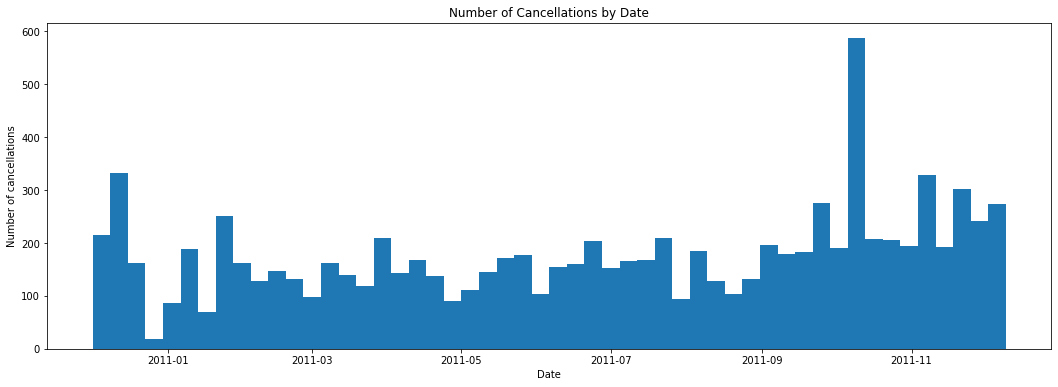

In [9]:
_ = plt.figure(figsize=[18,6])
_ = plt.hist(cancelled['InvoiceDate'], bins=52)
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of cancellations')
_ = plt.title('Number of Cancellations by Date')
plt.show()

I notice that there is a peak well above the rest around 2011-10. I looked a little closer to try to find a more specific range.

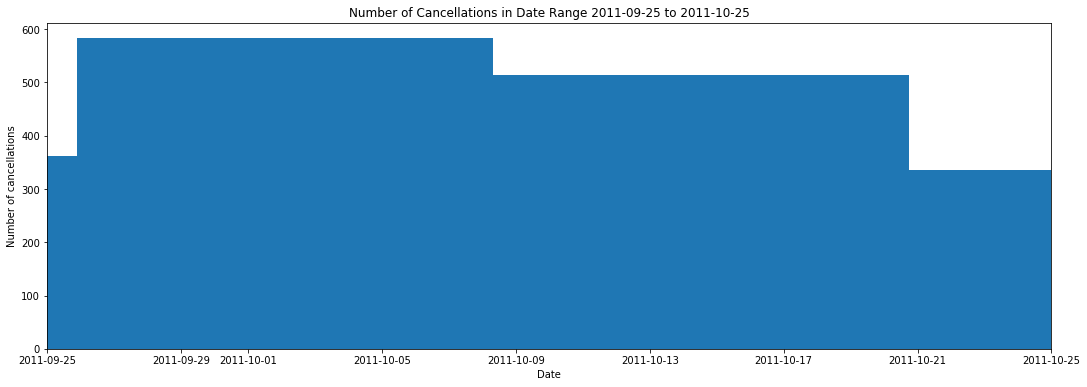

In [10]:
min_date = np.datetime64('2011-09-25')
max_date = np.datetime64('2011-10-25')
_ = plt.figure(figsize=[18,6])
_ = plt.hist(cancelled['InvoiceDate'], bins=30)
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of cancellations')
_ = plt.title('Number of Cancellations in Date Range 2011-09-25 to 2011-10-25')
_ = plt.xlim(min_date, max_date)
plt.show()

I wanted to see if those spikes coincided with holidays at all (which would likely be times of increased gift purchasing. I made an excel spreadsheet from the UK holidays listed on this website: https://www.timeanddate.com/holidays/uk/2011

In [11]:
holidays = pd.read_excel('Holidays.xlsx')
holidays.head()

,Date,DayOfWeek,Name,Type,Details
0,2011-01-01,Saturday,New Year's Day,Bank holiday,NaN
1,2011-01-03,Monday,New Year's Day observed,Bank holiday,NaN
2,2011-01-03,Monday,New Year's Day Holiday,Bank holiday,NaN
3,2011-01-04,Tuesday,2nd January (substitute day),Local Bank Holiday,Scotland
4,2011-01-06,Thursday,Epiphany,Christian,NaN


In [12]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 5 columns):
Date         95 non-null datetime64[ns]
DayOfWeek    95 non-null object
Name         95 non-null object
Type         95 non-null object
Details      10 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 3.8+ KB


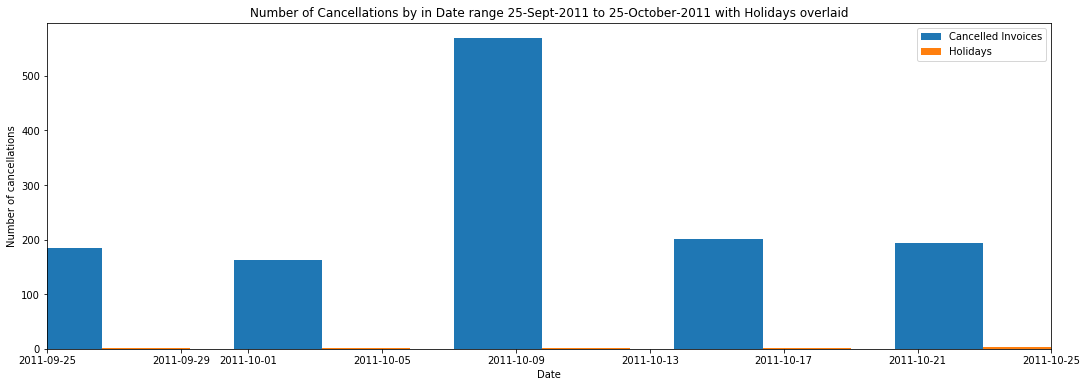

In [13]:
_ = plt.figure(figsize=[18,6])
_ = plt.hist([cancelled['InvoiceDate'], holidays['Date']], bins=60, label=['Cancelled Invoices', 'Holidays'])
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of cancellations')
_ = plt.title('Number of Cancellations by in Date range 25-Sept-2011 to 25-October-2011 with Holidays overlaid')
_ = plt.legend(loc='upper right')
_ = plt.xlim(min_date, max_date)
plt.show()

I found which holiday(s) are in the the range of 09-October-2011. Looks like primarily Jewish holidays that are not tied with gift giving. 

In [14]:
holidays_by_date = holidays.set_index(['Date'])
holidays_by_date.loc['2011-09-25':'2011-10-21']

,DayOfWeek,Name,Type,Details
Date,,,,
2011-09-28,Wednesday,Navaratri,Hindu Holiday,NaN
2011-09-29,Thursday,Rosh Hashana,Jewish holiday,NaN
2011-10-04,Tuesday,Feast of St Francis of Assisi,Christian,NaN
2011-10-06,Thursday,Dussehra,Hindu Holiday,NaN
2011-10-08,Saturday,Yom Kippur,Jewish holiday,NaN
2011-10-13,Thursday,First day of Sukkot,Jewish holiday,NaN
2011-10-19,Wednesday,Hoshana Rabbah,Jewish holiday,NaN
2011-10-20,Thursday,Shemini Atzeret,Jewish holiday,NaN
2011-10-21,Friday,Simchat Torah,Jewish holiday,NaN


I also looked at the holidays 30 days prior to see if there was anything of note.

In [15]:
holidays_by_date.loc['2011-08-25':'2011-09-25']

,DayOfWeek,Name,Type,Details
Date,,,,
2011-08-26,Friday,Laylatul Qadr (Night of Power),Muslim,NaN
2011-08-29,Monday,Summer Bank Holiday,Common local holiday,"ENG, NIR, WAL"
2011-08-31,Wednesday,Eid ul Fitr,Muslim,NaN
2011-09-01,Thursday,Ganesh Chaturthi,Hindu Holiday,NaN
2011-09-23,Friday,September Equinox,Season,NaN


None of those seem like likely reasons for the big spike in returns. I completed a brief search for top news stories in the UK around that time and found that unemployment was having “the largest increase in nearly two years” which may be a contributing factor. 
https://www.bbc.com/news/business-14912236

I looked to see if there was a day of the week that seemed to correspond to more (or fewer) cancellations than the others. I added a column to correspond to day of the week, noting from the documentation that Monday=0 to Sunday=6. Code is above to carry over to all subsections of retail dataframe. 

(When I initially attempted this, the days of the week were not accurate. I reset the index on the cancelled data frame to see if this was this issue, and that seemed to fix it.)

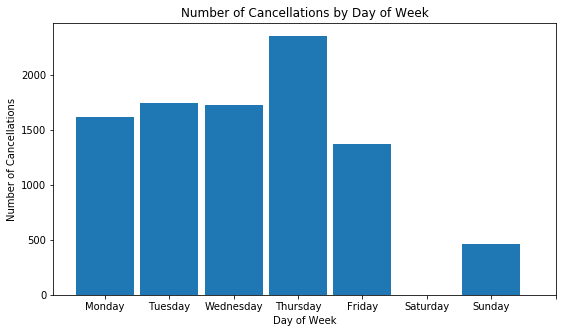

In [16]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_int = [0,1,2,3,4,5,6,7]
_ = plt.figure(figsize=[9,5])
_ = plt.hist(cancelled['WeekdayNum'], bins=weekday_int, align='left', rwidth=0.9)
_ = plt.xticks(ticks=weekday_int, labels=days_of_week)
_ = plt.xlabel('Day of Week')
_ = plt.ylabel('Number of Cancellations')
_ = plt.title('Number of Cancellations by Day of Week')
plt.show()

From the looks of the plot, the most returns happen on a Thursday and no returns happened on Saturday. I did a search for this, because this felt suspect, however no results came up for cancelled invoices on a Saturday

In [17]:
cancelled.loc[cancelled['Weekday'] =='Saturday']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Weekday,WeekdayNum,DateSec,CountryNum


In [18]:
monday_c = cancelled['Weekday'] =='Monday'
tuesday_c = cancelled['Weekday'] =='Tuesday'
wednesday_c = cancelled['Weekday'] =='Wednesday'
thursday_c = cancelled['Weekday'] =='Thursday'
friday_c = cancelled['Weekday'] =='Friday'
saturday_c = cancelled['Weekday'] =='Saturday'
sunday_c = cancelled['Weekday'] =='Sunday'

In [19]:
print('ANOVA for all days of week:', stats.f_oneway(monday_c, tuesday_c, wednesday_c, thursday_c, friday_c, saturday_c, sunday_c))

ANOVA for all days of week: F_onewayResult(statistic=617.5717931790023, pvalue=0.0)


For this, we can say that there it is statistically unlikely that the difference observed between all days of the week was due to chance.

I noted that there are 9288 cancelled orders, so I pulled out the top 20 most commonly cancelled orders. 

In [20]:
can_top20_count = cancelled['Description'].value_counts().head(20)
can_top20_count

Manual                                244
REGENCY CAKESTAND 3 TIER              181
POSTAGE                               126
JAM MAKING SET WITH JARS               87
Discount                               77
SET OF 3 CAKE TINS PANTRY DESIGN       74
SAMPLES                                61
STRAWBERRY CERAMIC TRINKET BOX         55
ROSES REGENCY TEACUP AND SAUCER        54
RECIPE BOX PANTRY YELLOW DESIGN        47
WOOD 2 DRAWER CABINET WHITE FINISH     45
JUMBO BAG RED RETROSPOT                44
LUNCH BAG RED RETROSPOT                44
GREEN REGENCY TEACUP AND SAUCER        42
WHITE HANGING HEART T-LIGHT HOLDER     42
RED RETROSPOT CAKE STAND               42
SMALL GLASS HEART TRINKET POT          40
SET OF 3 REGENCY CAKE TINS             37
POPCORN HOLDER                         36
PINK REGENCY TEACUP AND SAUCER         35
Name: Description, dtype: int64

In [21]:
can_top20 = pd.DataFrame(can_top20_count).reset_index()
#renaming columns to better represent the description and their value counts
can_top20 = can_top20.rename(columns={"index":"Description", "Description":"ValueCount"})
can_top20

,Description,ValueCount
0,Manual,244
1,REGENCY CAKESTAND 3 TIER,181
2,POSTAGE,126
3,JAM MAKING SET WITH JARS,87
4,Discount,77
5,SET OF 3 CAKE TINS PANTRY DESIGN,74
6,SAMPLES,61
7,STRAWBERRY CERAMIC TRINKET BOX,55
8,ROSES REGENCY TEACUP AND SAUCER,54
9,RECIPE BOX PANTRY YELLOW DESIGN,47


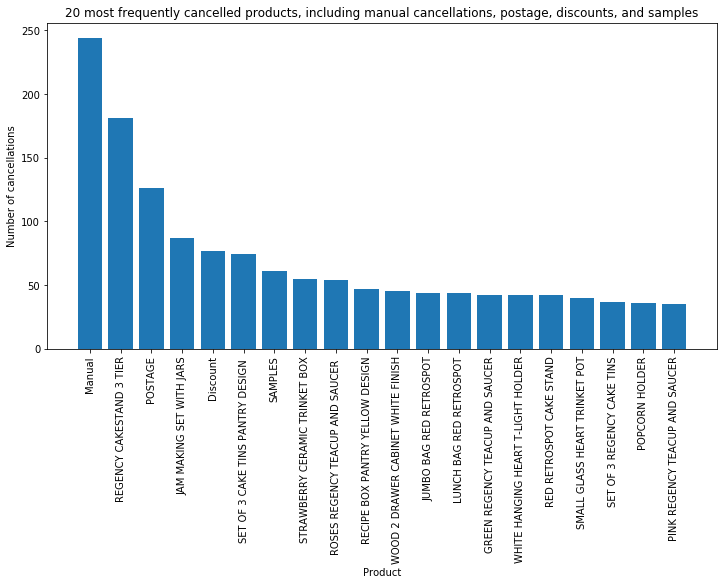

In [22]:
_ = plt.figure(figsize=[12,6])
_ = plt.bar(can_top20['Description'], height=can_top20['ValueCount'])
_ = plt.xlabel('Product')
_ = plt.xticks(rotation=90)
_ = plt.ylabel('Number of cancellations')
_ = plt.title('20 most frequently cancelled products, including manual cancellations, postage, discounts, and samples')
plt.show()

#### <span style='color:Blue'> Observations:  </span>
- Notice that "Manual" is the most common...wonder if this is a manual return? 
- postage, discount, and samples high on list. 
    - Consider removing discount? 
    - Determine if certain products more frequently receive discounts?
        - may not be able to determine as discounts are not tied to which product?
    - Same line of thought with samples
- question if postage is a product sold or if this represents postage paid out?
- graph above represents products most frequently appearing on cancellation list. Does not account for numbers returned

I looked to see if manual cancellation was more common during a given time of year. I pulled only the manually cancelled invoices and noted that the number of rows is consistent with the number of manual cancels from the top 20 list, so I feel confident that I grabbed them all

In [23]:
manual = cancelled.loc[cancelled['Description'].str.contains('Manual', na=False)]
manual

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Weekday,WeekdayNum,DateSec,CountryNum
14716,C537610,M,Manual,-1,2010-12-07 13:23:00,631.31,NaN,United Kingdom,Tuesday,1,1291728180000000000,0
14728,C537613,M,Manual,-1,2010-12-07 13:28:00,313.78,NaN,United Kingdom,Tuesday,1,1291728480000000000,0
21758,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom,Thursday,3,1291909380000000000,0
23241,C538189,M,Manual,-1,2010-12-10 10:35:00,133.08,NaN,United Kingdom,Friday,4,1291977300000000000,0
28993,C538681,M,Manual,-1,2010-12-13 17:12:00,316.30,NaN,United Kingdom,Monday,0,1292260320000000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
520134,C580263,M,Manual,-16,2011-12-02 12:43:00,0.29,12536.0,France,Friday,4,1322829780000000000,1
523375,C580510,M,Manual,-1,2011-12-04 13:48:00,1.25,14456.0,United Kingdom,Sunday,6,1323006480000000000,0
533082,C581009,M,Manual,-1,2011-12-07 09:15:00,125.00,16971.0,United Kingdom,Wednesday,2,1323249300000000000,0
534308,C581145,M,Manual,-1,2011-12-07 13:48:00,9.95,17490.0,United Kingdom,Wednesday,2,1323265680000000000,0


I plotted the quantity of manual cancellations versus time. This shows total number of products cancelled, but may be misleading, as a single order of high quantity could easily skew the data. 

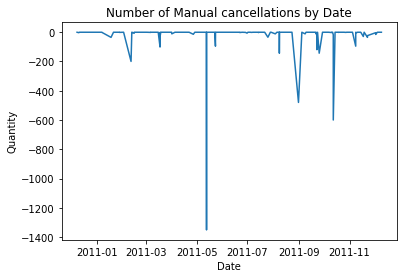

In [24]:
_ = plt.plot(manual['InvoiceDate'], manual['Quantity'])
_ = plt.xlabel('Date')
_ = plt.ylabel('Quantity')
_ = plt.title('Number of Manual cancellations by Date')
plt.show()

I then looked at a histogram of cancellations, to get a better sense of when cancellations are most frequently occuring. I selected 52 bins as there are 52 weeks in the year 

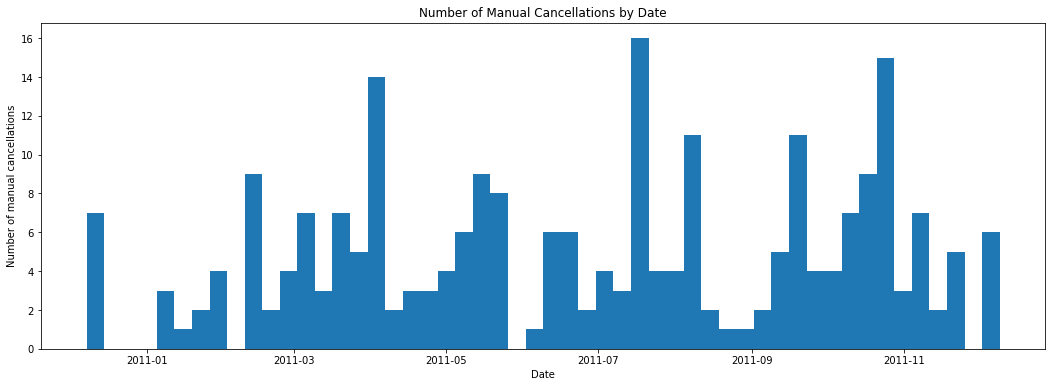

In [25]:
_ = plt.figure(figsize=[18,6])
_ = plt.hist(manual['InvoiceDate'], bins=52)
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of manual cancellations')
_ = plt.title('Number of Manual Cancellations by Date')
plt.show()

Again, I plotted this against holidays

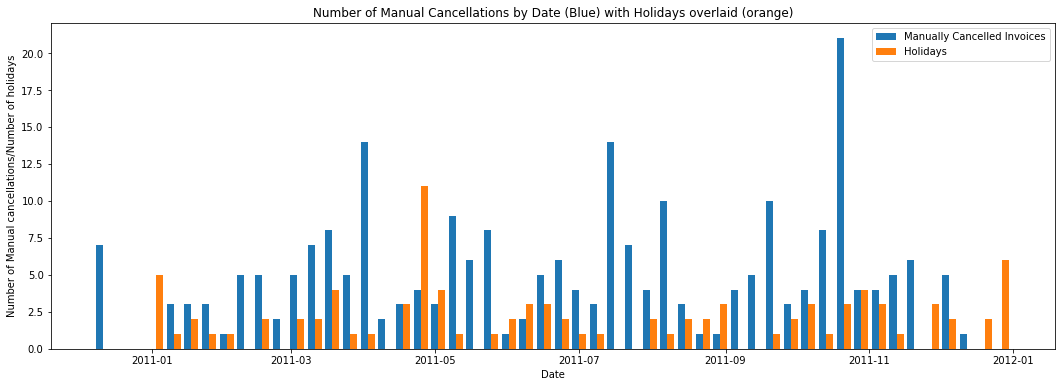

In [26]:
_ = plt.figure(figsize=[18,6])
_ = plt.hist([manual['InvoiceDate'], holidays['Date']], bins=52, label=['Manually Cancelled Invoices', 'Holidays'])
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of Manual cancellations/Number of holidays')
_ = plt.title('Number of Manual Cancellations by Date (Blue) with Holidays overlaid (orange)')
_ = plt.legend(loc='upper right')
plt.show()

Looks like two of the highest cancellation times coincide with holidays

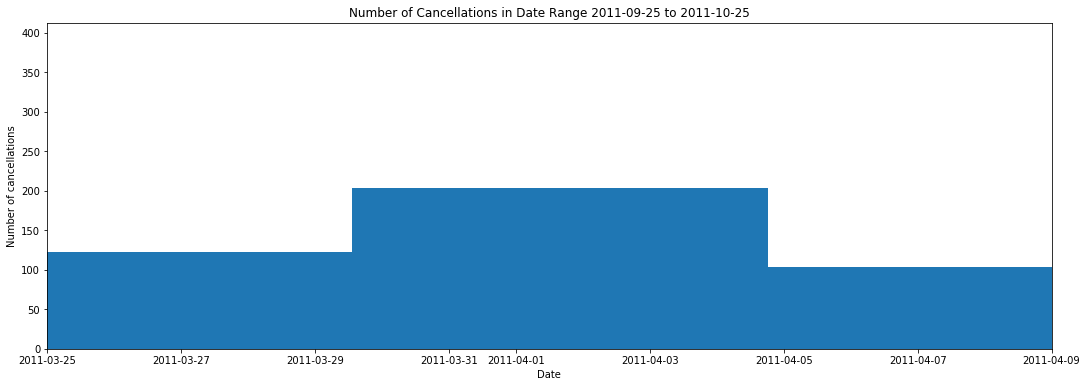

In [27]:
min_date_march = np.datetime64('2011-03-25')
max_date_april = np.datetime64('2011-04-09')
_ = plt.figure(figsize=[18,6])
_ = plt.hist(cancelled['InvoiceDate'], bins=60)
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of cancellations')
_ = plt.title('Number of Cancellations in Date Range 2011-09-25 to 2011-10-25')
_ = plt.xlim(min_date_march, max_date_april)
plt.show()

In [28]:
holidays_by_date = holidays.set_index(['Date'])
holidays_by_date.loc['2011-03-25':'2011-04-09']

,DayOfWeek,Name,Type,Details
Date,,,,
2011-03-27,Sunday,Daylight Saving Time starts,Clock change/Daylight Saving Time,NaN
2011-04-03,Sunday,Mothering Sunday,Observance,NaN


a quick google search suggests that Mothering Sunday is not the same as mother's day and is a Christian holiday. We know from the looking at the manual cancellations that there is not a holiday of note in the November time-frame

If we assume that "manual" is an override that doesn't differentiate into individual products, that samples shouldn't be counted, and that discounts and postage are not to be included, then the top 20 most cancelled products looks more like this:

In [29]:
#adding additional rows
#decided to add 30 rows to account for ties: can_prod_count for cancelled products
can_prod_count = cancelled['Description'].value_counts().head(30)
can_prod = pd.DataFrame(can_prod_count).reset_index()
#renaming columns to better represent the description and their value counts
can_prod = can_prod.rename(columns={"index":"Description", "Description":"ValueCount"})
#dropping rows for manual, postage, discount, samples and re-setting the index
can_prod = can_prod.drop([0,2,4,6]).reset_index(drop=True)
#selecting top 20 from new list
#I did look at the top 25 to make sure my final item was not in a tie with the next item. It is not, so I selected only the top 20 products again
can_prod = can_prod.head(20)
can_prod

,Description,ValueCount
0,REGENCY CAKESTAND 3 TIER,181
1,JAM MAKING SET WITH JARS,87
2,SET OF 3 CAKE TINS PANTRY DESIGN,74
3,STRAWBERRY CERAMIC TRINKET BOX,55
4,ROSES REGENCY TEACUP AND SAUCER,54
5,RECIPE BOX PANTRY YELLOW DESIGN,47
6,WOOD 2 DRAWER CABINET WHITE FINISH,45
7,JUMBO BAG RED RETROSPOT,44
8,LUNCH BAG RED RETROSPOT,44
9,GREEN REGENCY TEACUP AND SAUCER,42


Now, a hopefully more accurate picture of the top 20 most cancelled products would look like this:

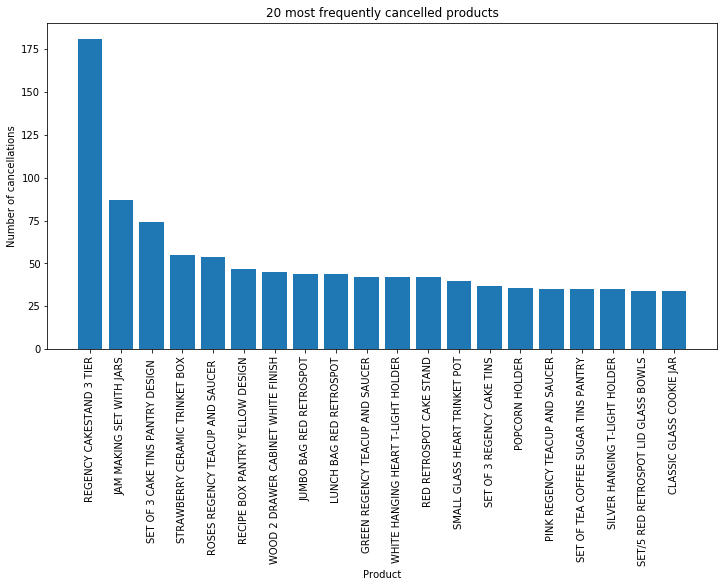

In [30]:
_ = plt.figure(figsize=[12,6])
_ = plt.bar(can_prod['Description'], height=can_prod['ValueCount'])
_ = plt.xlabel('Product')
_ = plt.xticks(rotation=90)
_ = plt.ylabel('Number of cancellations')
_ = plt.title('20 most frequently cancelled products')
plt.show()

I wanted to look at if there is a customer that cancels orders more frequently. I realized that I was using similar code, so I wrote a function to pull the top n values of a given column

In [31]:
can_cust = get_top_nums(cancelled, 'CustomerID', 10)
can_cust

,CustomerID,ValueCount
0,14911.0,226
1,17841.0,136
2,17511.0,113
3,15311.0,112
4,12607.0,101
5,14410.0,93
6,13798.0,90
7,14606.0,82
8,13113.0,79
9,12471.0,71


Looks like customer 14911 has almost 100 more cancelled orders than the next most common customer. I dug in and looked at what they were ordering, to see if there is a pattern

In [32]:
can_cust_1 = cancelled.loc[cancelled['CustomerID']==14911.0]
can_cust_1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Weekday,WeekdayNum,DateSec,CountryNum
33082,C539221,90185B,AMETHYST DIAMANTE EXPANDABLE RING,-3,2010-12-16 12:56:00,4.25,14911.0,EIRE,Thursday,3,1292504160000000000,6
33083,C539221,90185C,BLACK DIAMANTE EXPANDABLE RING,-4,2010-12-16 12:56:00,4.25,14911.0,EIRE,Thursday,3,1292504160000000000,6
33084,C539221,22592,CARDHOLDER HOLLY WREATH METAL,-1,2010-12-16 12:56:00,3.75,14911.0,EIRE,Thursday,3,1292504160000000000,6
33085,C539221,22941,CHRISTMAS LIGHTS 10 REINDEER,-12,2010-12-16 12:56:00,8.50,14911.0,EIRE,Thursday,3,1292504160000000000,6
33086,C539221,22942,CHRISTMAS LIGHTS 10 SANTAS,-10,2010-12-16 12:56:00,8.50,14911.0,EIRE,Thursday,3,1292504160000000000,6
...,...,...,...,...,...,...,...,...,...,...,...,...
481917,C577388,23454,THREE MINI HANGING FRAMES,-2,2011-11-18 16:58:00,4.15,14911.0,EIRE,Friday,4,1321635480000000000,6
481918,C577388,21429,RED GINGHAM ROSE JEWELLERY BOX,-2,2011-11-18 16:58:00,1.95,14911.0,EIRE,Friday,4,1321635480000000000,6
481919,C577388,23118,PARISIENNE JEWELLERY DRAWER,-1,2011-11-18 16:58:00,7.50,14911.0,EIRE,Friday,4,1321635480000000000,6
488490,C577828,23318,BOX OF 6 MINI VINTAGE CRACKERS,-11,2011-11-22 09:53:00,2.08,14911.0,EIRE,Tuesday,1,1321955580000000000,6


I also looked at the countries that cancel most frequently. Since it is a UK-based company, having the most cancellations in-country makes sense.

In [33]:
can_country = get_top_nums(cancelled, 'Country', 5)
can_country

,Country,ValueCount
0,United Kingdom,7856
1,Germany,453
2,EIRE,302
3,France,149
4,USA,112


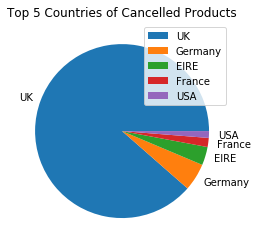

In [34]:
#pie chart of country data above
_ = plt.pie(can_country['ValueCount'], labels=['UK', 'Germany', 'EIRE', 'France', 'USA'])
_ = plt.title('Top 5 Countries of Cancelled Products')
_ = plt.legend()
plt.show()

After exploring the data, I used k-means clustering to attempt to elicit patterns from the data, based on customer ID

First, I checked for normalcy of data by price and by quantity and removed outliers

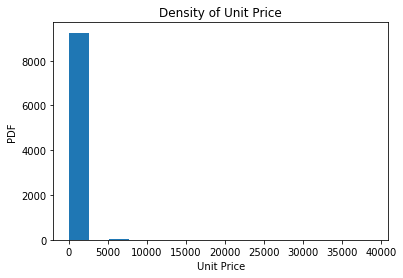

In [35]:
_ = plt.hist(cancelled['UnitPrice'], bins=15)
_ = plt.xlabel("Unit Price")
_ = plt.ylabel("PDF")
_ = plt.title("Density of Unit Price")
plt.show()

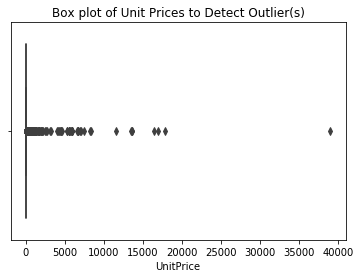

In [36]:
_ = sns.boxplot(x=cancelled['UnitPrice'])
_ = plt.title('Box plot of Unit Prices to Detect Outlier(s)')
plt.show()

In [37]:
#calculating z-score to determine outliers
z = np.abs(stats.zscore(cancelled['UnitPrice']))
print(np.where(z > 3))
print("Outliers: ", len(z))

(array([ 177,  178,  179,  180,  181,  742,  743, 1837, 1838, 2176, 2267,
       2268, 2657, 2660, 3201, 3202, 3423, 3424, 4014, 4343, 4344, 4737,
       4738, 4831, 4971, 5188, 5189, 5336, 5651, 5652, 6154, 6155, 6231,
       6992, 7505, 7506, 7789, 7849, 7850, 8088, 8090, 9061, 9062],
      dtype=int64),)
Outliers:  9288


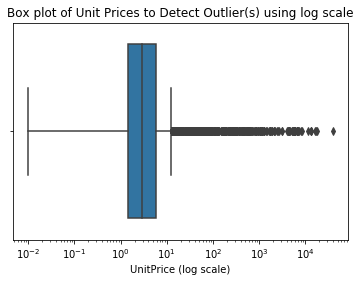

In [38]:
#re-drawing boxplot with log scale to better visualize data and outlier(s)
f, ax = plt.subplots()
sns.boxplot(x=cancelled['UnitPrice'])
ax.set_xscale('log')
plt.xlabel('UnitPrice (log scale)')
plt.title('Box plot of Unit Prices to Detect Outlier(s) using log scale')
plt.show()

It would appear that everything above 10 Pounds is an outlier and can be removed from the dataframe. After removing these, I checked to make sure I still had a decent number of rows in my data frame. Dropping these rows only eliminated ~1000 rows

In [39]:
cancelled.drop(cancelled[cancelled['UnitPrice'] > 10].index, inplace=True)
cancelled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8211 entries, 154 to 541717
Data columns (total 12 columns):
InvoiceNo      8211 non-null object
StockCode      8211 non-null object
Description    8211 non-null object
Quantity       8211 non-null int64
InvoiceDate    8211 non-null datetime64[ns]
UnitPrice      8211 non-null float64
CustomerID     8024 non-null float64
Country        8211 non-null object
Weekday        8211 non-null object
WeekdayNum     8211 non-null int64
DateSec        8211 non-null int64
CountryNum     8211 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 833.9+ KB


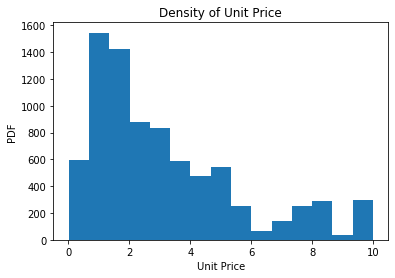

In [40]:
#new histogram. Still not a normal distribution, but improved
_ = plt.hist(cancelled['UnitPrice'], bins=15)
_ = plt.xlabel("Unit Price")
_ = plt.ylabel("PDF")
_ = plt.title("Density of Unit Price")
plt.show()

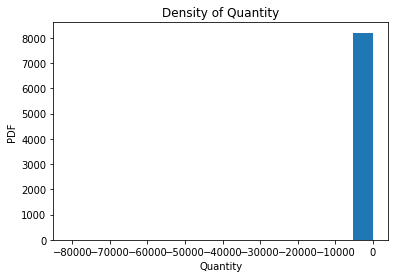

In [41]:
#histogram for quantity
_ = plt.hist(cancelled['Quantity'], bins=15)
_ = plt.xlabel("Quantity")
_ = plt.ylabel("PDF")
_ = plt.title("Density of Quantity")
plt.show()

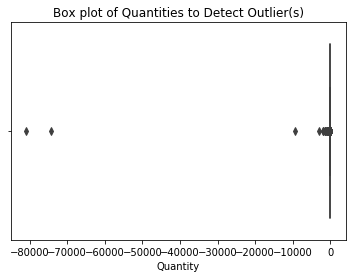

In [42]:
#detecting quantity outliers
_ = sns.boxplot(x=cancelled['Quantity'])
_ = plt.title('Box plot of Quantities to Detect Outlier(s)')
plt.show()

In [43]:
#calculating z-score to determine outliers
z = np.abs(stats.zscore(cancelled['Quantity']))
print(np.where(z > 3))
print("Outliers: ", len(z))

(array([  31,  919, 8206], dtype=int64),)
Outliers:  8211


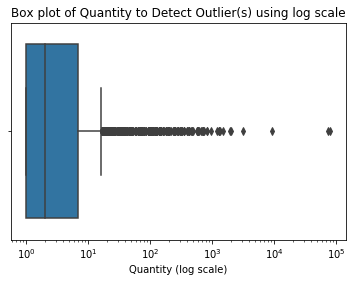

In [44]:
#re-drawing boxplot with log scale to better visualize data and outlier(s)
#did convert quantity to all positive numbers using absolute value for better visualization
f, ax = plt.subplots()
sns.boxplot(x=np.absolute(cancelled['Quantity']))
ax.set_xscale('log')
plt.xlabel('Quantity (log scale)')
plt.title('Box plot of Quantity to Detect Outlier(s) using log scale')
plt.show()

The outliers appear to begin just above 10 units again. I'll utilize 15 units to err on the side of including an outlier rather than excluding. 

In [45]:
cancelled.drop(cancelled[np.absolute(cancelled['Quantity']) > 15].index, inplace=True)
cancelled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7199 entries, 154 to 541717
Data columns (total 12 columns):
InvoiceNo      7199 non-null object
StockCode      7199 non-null object
Description    7199 non-null object
Quantity       7199 non-null int64
InvoiceDate    7199 non-null datetime64[ns]
UnitPrice      7199 non-null float64
CustomerID     7049 non-null float64
Country        7199 non-null object
Weekday        7199 non-null object
WeekdayNum     7199 non-null int64
DateSec        7199 non-null int64
CountryNum     7199 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 731.1+ KB


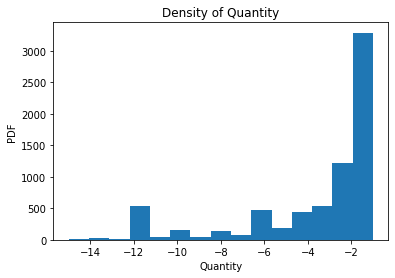

In [46]:
#histogram for quantity again. Improved from before after removing outliers. 
_ = plt.hist(cancelled['Quantity'], bins=15)
_ = plt.xlabel("Quantity")
_ = plt.ylabel("PDF")
_ = plt.title("Density of Quantity")
plt.show()

### <span style='color:blue'> k-means clustering analysis  </span>

Now I was ready to complete a KMeans unsupervised clustering. I utilized the categories of quantity, unit price, weekday (numerical code), country(numerical code), and invoice date (expressed numerically as seconds). 

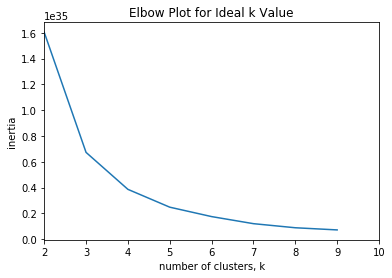

In [47]:
x_cols = list(cancelled[['Quantity', 'UnitPrice', 'WeekdayNum', 'DateSec', 'CountryNum']])

data = cancelled[x_cols]

#re-determining optimal k-value
ks = range(2,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(data)
    inertias.append(model.inertia_)
    

_ = plt.plot(ks, inertias)
_ = plt.xlim(2,10)
_ = plt.xlabel('number of clusters, k')
_ = plt.ylabel('inertia')
_ = plt.title('Elbow Plot for Ideal k Value')
plt.show()

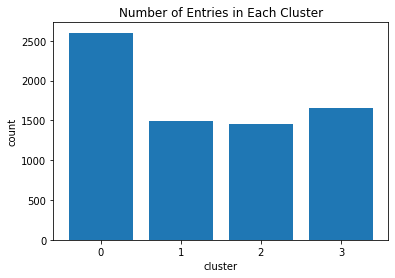

In [48]:
cluster = KMeans(n_clusters=4)

nums = cluster.fit_predict(data)

num_count = pd.Series.value_counts(nums)

_ = plt.bar(x=num_count.index, height=num_count)
_ = plt.xlabel('cluster')
_ = plt.xticks(np.arange(0,4, 1))
_ = plt.ylabel('count')
_ = plt.title('Number of Entries in Each Cluster')
plt.show()

7199


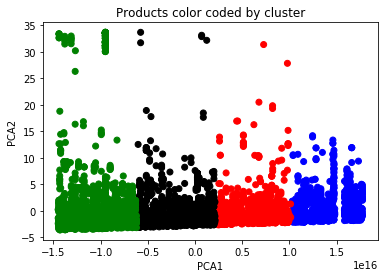

In [49]:
X = np.array(data)

model = KMeans(n_clusters=4)
cluster_assignments = model.fit_predict(X)


print(len(cluster_assignments))
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue', 'black'])

pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
_ = plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)
_ = plt.xlabel('PCA1')
_ = plt.ylabel('PCA2')
_ = plt.title('Products color coded by cluster')
plt.show()

In [50]:
print("Number of values in cluster 1 (red): ", len(data[cluster_assignments ==0]))
print("Number of values in cluster 2 (green): ", len(data[cluster_assignments ==1]))
print("Number of values in cluster 3 (blue): ", len(data[cluster_assignments ==2]))
print("Number of values in cluster 4 (black): ", len(data[cluster_assignments ==3]))

Number of values in cluster 1 (red):  1457
Number of values in cluster 2 (green):  2601
Number of values in cluster 3 (blue):  1487
Number of values in cluster 4 (black):  1654


There are definitely the most products in the first cluster, but they are fairly evenly spread in the remaining 3. I looked further at the products in each cluster.

In [51]:
cluster_0 = data[cluster_assignments ==0]
cluster_0.head()

,Quantity,UnitPrice,WeekdayNum,DateSec,CountryNum
102859,-1,3.00,6,1298802300000000000,0
103549,-11,2.95,6,1298819220000000000,0
104698,-1,1.95,0,1298906340000000000,0
105762,-1,1.25,1,1298979060000000000,0
106054,-1,7.95,1,1298984700000000000,0


In [52]:
#converting epoch time back to datetime in correct timezone (UTC) to make it more readable
datetime.datetime.utcfromtimestamp(1315138500).strftime('%Y-%m-%d %H:%M:%S')

'2011-09-04 12:15:00'

In [53]:
#double checking that this provides the correct date back, which it does
cancelled.loc[cancelled['DateSec'] == 1315138500000000000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Weekday,WeekdayNum,DateSec,CountryNum
324904,C565422,22776,SWEETHEART 3 TIER CAKE STAND,-1,2011-09-04 12:15:00,9.95,17774.0,United Kingdom,Sunday,6,1315138500000000000,0


In [54]:
#converting all DateSec columns to datetimes. The following code is commented out to save space
#I found when exploring the data in each cluster that they appear to be clustered by date only
#cluster_0['Date'] = pd.to_datetime(cluster_0['DateSec'])
#cluster_0.tail(25)

#cluster_1 = data[cluster_assignments ==1]
#cluster_1['Date'] = pd.to_datetime(cluster_1['DateSec'])
#cluster_1.tail(25)

#cluster_2 = data[cluster_assignments ==2]
#cluster_2['Date'] = pd.to_datetime(cluster_2['DateSec'])
#cluster_2.tail(25)

#cluster_3 = data[cluster_assignments ==3]
#cluster_3['Date'] = pd.to_datetime(cluster_3['DateSec'])
#cluster_3.tail(25)

After the first attempt at KMeans clustering, I realized that the clustering algorithm simply broke the products up into 4 clusters by date. I removed the date as an input to see if I could garner any other pattern with clustering. I found the optimal k-value first and completed a KMeans accordingly

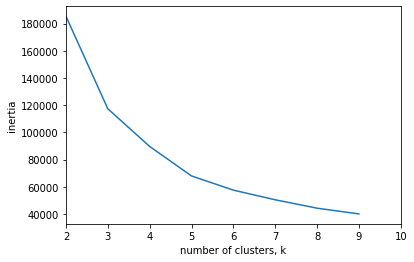

In [55]:
x_cols = list(cancelled[['Quantity', 'UnitPrice', 'WeekdayNum', 'CountryNum']])

data = cancelled[x_cols]

#re-determining optimal k-value
ks = range(2,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(data)
    inertias.append(model.inertia_)
    

_ = plt.plot(ks, inertias)
_ = plt.xlim(2,10)
_ = plt.xlabel('number of clusters, k')
_ = plt.ylabel('inertia')
plt.show()

7199


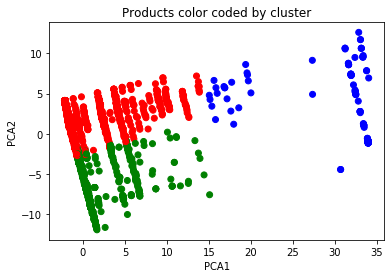

In [56]:
X = np.array(data)

model = KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(X)


print(len(cluster_assignments))
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])

pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
_ = plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)
_ = plt.xlabel('PCA1')
_ = plt.ylabel('PCA2')
_ = plt.title('Products color coded by cluster')
plt.show()

In [57]:
cluster_0 = data[cluster_assignments ==0]
cluster_0.describe()

,Quantity,UnitPrice,WeekdayNum,CountryNum
count,5665.000000,5665.000000,5665.000000,5665.000000
mean,-1.798235,3.757041,2.265843,0.699559
std,1.167654,2.598772,1.595901,2.171604
min,-6.000000,0.120000,0.000000,0.000000
25%,-2.000000,1.650000,1.000000,0.000000
50%,-1.000000,2.950000,2.000000,0.000000
75%,-1.000000,4.950000,3.000000,0.000000
max,-1.000000,10.000000,6.000000,16.000000


In [58]:
cluster_1 = data[cluster_assignments ==1]
cluster_1.describe()

,Quantity,UnitPrice,WeekdayNum,CountryNum
count,1413.000000,1413.000000,1413.000000,1413.000000
mean,-9.364473,2.057233,2.186837,0.825195
std,2.669110,1.536408,1.533081,2.189309
min,-15.000000,0.120000,0.000000,0.000000
25%,-12.000000,1.250000,1.000000,0.000000
50%,-10.000000,1.650000,2.000000,0.000000
75%,-6.000000,2.550000,3.000000,0.000000
max,-5.000000,10.000000,6.000000,14.000000


In [59]:
cluster_2 = data[cluster_assignments ==2]
cluster_2.describe()

,Quantity,UnitPrice,WeekdayNum,CountryNum
count,121.000000,121.000000,121.000000,121.000000
mean,-6.842975,2.696694,2.074380,31.669421
std,4.421554,2.081542,0.787033,5.670668
min,-15.000000,0.390000,0.000000,17.000000
25%,-12.000000,1.250000,2.000000,34.000000
50%,-6.000000,2.080000,2.000000,34.000000
75%,-3.000000,3.950000,2.000000,34.000000
max,-1.000000,9.950000,4.000000,36.000000


For n_clusters = 2 The average silhouette_score is : 0.7985072820144479
For n_clusters = 3 The average silhouette_score is : 0.4552783213039024
For n_clusters = 4 The average silhouette_score is : 0.3886195633267746


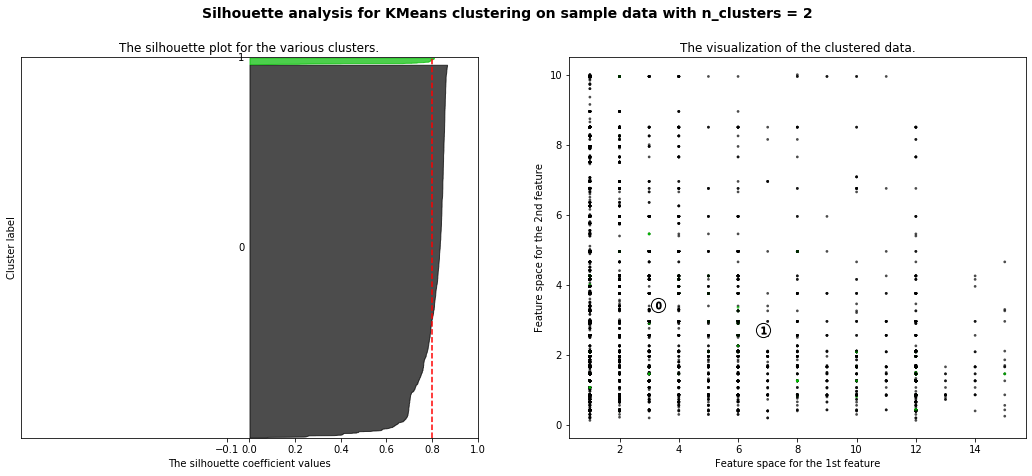

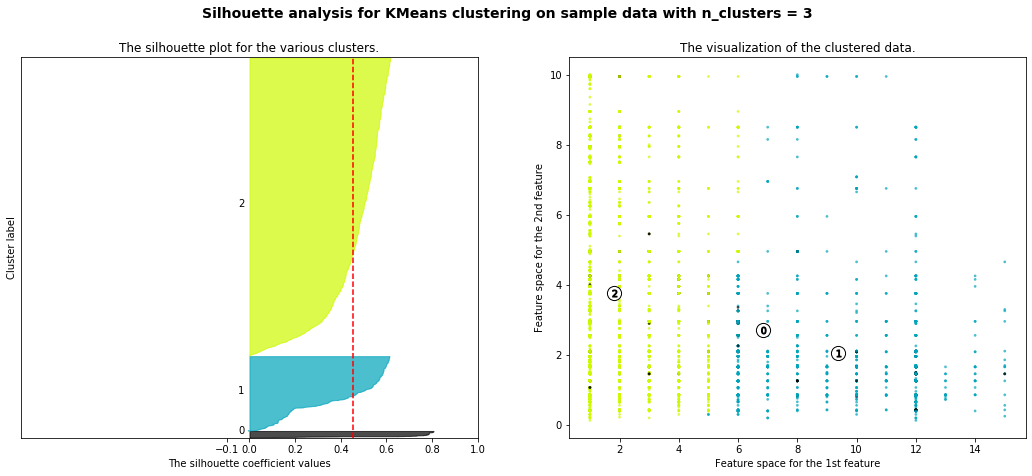

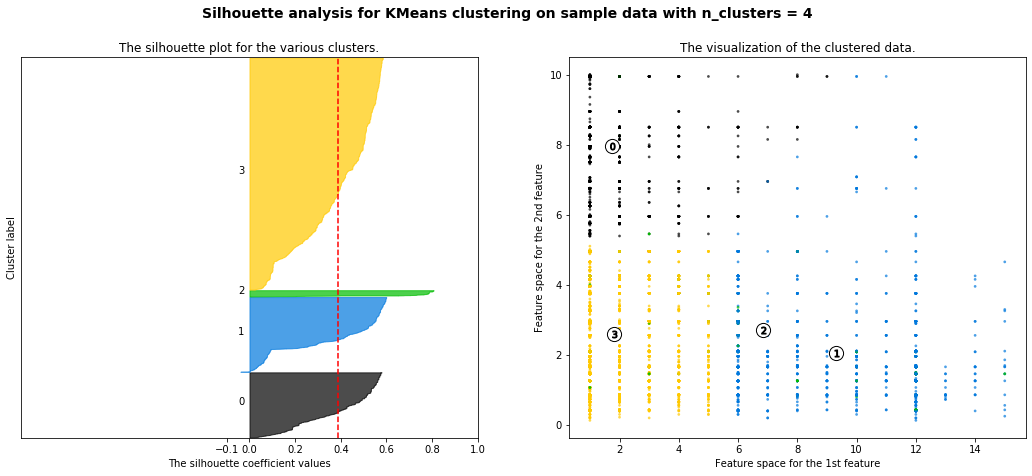

In [60]:
#evaluating the effectiveness of the clusters using silhouette scores
columns = np.array(abs(cancelled[['Quantity', 'UnitPrice', 'WeekdayNum', 'CountryNum']]))

X = np.array(columns)
range_n_clusters = range(2,5)
silhouettes = []

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouettes.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

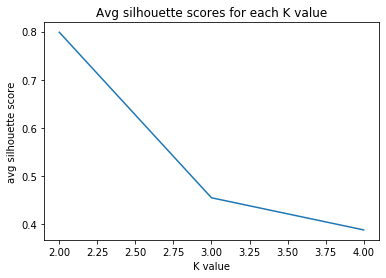

In [61]:
#Compute the average silhouette score for each  𝐾  and plot it. What  𝐾  does the plot suggest we should choose? Does it differ from what we found using the Elbow method?
_ = plt.plot(range_n_clusters, silhouettes)
_ = plt.xlabel('K value')
_ = plt.ylabel('avg silhouette score')
_ = plt.title('Avg silhouette scores for each K value')
plt.show()

even though there is a clear elbow at K=3, the only silhouette score that suggested a structure was K=2, which suggests a strong structure. (K=3 and K=4 suggest a weak and possibly artificial structure was found. 

So I re-clustered using only 2 clusters.

7199


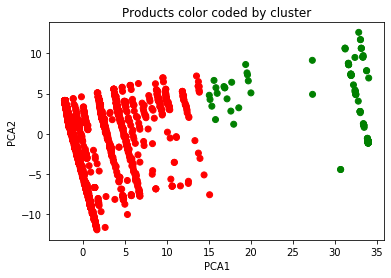

In [62]:
x_cols = list(cancelled[['Quantity', 'UnitPrice', 'WeekdayNum', 'CountryNum']])
data = cancelled[x_cols]

X = np.array(data)

model = KMeans(n_clusters=2)
cluster_assignments = model.fit_predict(X)


print(len(cluster_assignments))
cmap = matplotlib.colors.ListedColormap(['red', 'green'])

pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
_ = plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)
_ = plt.xlabel('PCA1')
_ = plt.ylabel('PCA2')
_ = plt.title('Products color coded by cluster')
plt.show()

In [63]:
cluster_0 = data[cluster_assignments ==0]
cluster_0.describe()

,Quantity,UnitPrice,WeekdayNum,CountryNum
count,7078.000000,7078.000000,7078.000000,7078.000000
mean,-3.308703,3.417704,2.250071,0.724640
std,3.414812,2.517515,1.583767,2.175575
min,-15.000000,0.120000,0.000000,0.000000
25%,-4.000000,1.490000,1.000000,0.000000
50%,-2.000000,2.890000,2.000000,0.000000
75%,-1.000000,4.950000,3.000000,0.000000
max,-1.000000,10.000000,6.000000,16.000000


In [64]:
cluster_1 = data[cluster_assignments ==1]
cluster_1.describe()

,Quantity,UnitPrice,WeekdayNum,CountryNum
count,121.000000,121.000000,121.000000,121.000000
mean,-6.842975,2.696694,2.074380,31.669421
std,4.421554,2.081542,0.787033,5.670668
min,-15.000000,0.390000,0.000000,17.000000
25%,-12.000000,1.250000,2.000000,34.000000
50%,-6.000000,2.080000,2.000000,34.000000
75%,-3.000000,3.950000,2.000000,34.000000
max,-1.000000,9.950000,4.000000,36.000000


Using only 2 clusters seems to have clustered the products by country purchased, as cluster 0 is country number 17-36 and cluster 1 is countries 0-16. I decided to look closer to see if there was anything else to be gained from this clustering, as I am questioning if there is a discernable pattern to clustering the entire cancelled dataframe. 

Text(0.5, 1, 'Quantity vs Price sorted by Country')

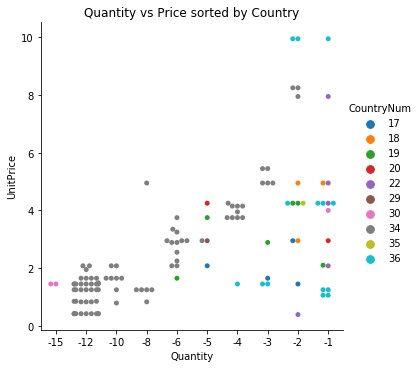

In [65]:
sns.catplot(x='Quantity', y='UnitPrice', hue='CountryNum', data=cluster_1, kind='swarm')
plt.title('Quantity vs Price sorted by Country')

Text(0.5, 1, 'Quantity vs Price sorted by Weekday')

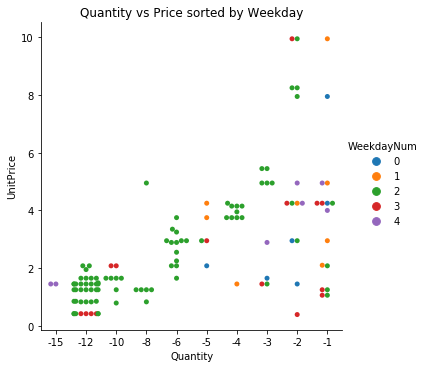

In [66]:
sns.catplot(x='Quantity', y='UnitPrice', hue='WeekdayNum', data=cluster_1, kind='swarm')
plt.title('Quantity vs Price sorted by Weekday')

I do notice that country 34 seems to align well with weekday 2 (which is a Wednesday), and that as quantity goes up, price goes down. 

In [67]:
print('country 34: ', countries[34])

country 34:  USA


Text(0.5, 1, 'Quantity and Price of Products Cancelled by USA')

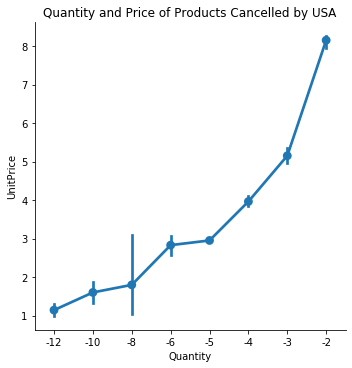

In [68]:
usa = cluster_1.loc[cluster_1['CountryNum'] == 34]
usa
sns.catplot(x='Quantity', y='UnitPrice', data=usa, kind='point')
plt.title('Quantity and Price of Products Cancelled by USA')


I looked closer at cluster 1 but didn't see any identifiable pattern outside country number

Text(0.5, 1, 'Quantity vs Price sorted by Country')

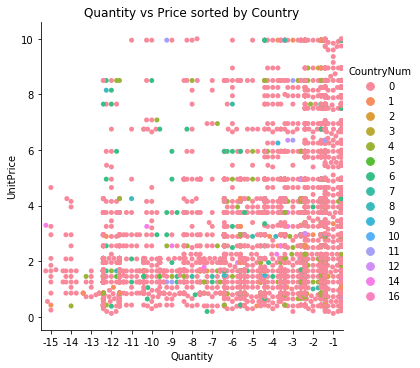

In [69]:
sns.catplot(x='Quantity', y='UnitPrice', hue='CountryNum', data=cluster_0, kind='swarm')
plt.title('Quantity vs Price sorted by Country')

Text(0.5, 1, 'Quantity vs Price sorted by Weekday')

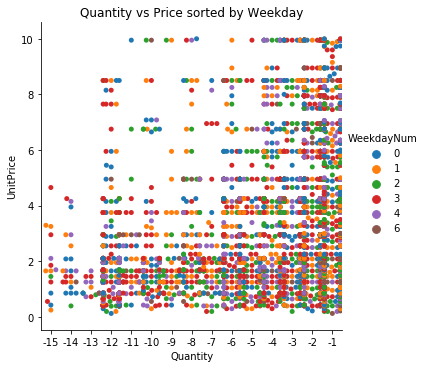

In [70]:
sns.catplot(x='Quantity', y='UnitPrice', hue='WeekdayNum', data=cluster_0, kind='swarm')
plt.title('Quantity vs Price sorted by Weekday')

With the attempt at clustering yielding only 2 clusters, this does not seem to be the best metric for prediction. I shifted to completing a time series analysis to attempt to predict customer behavior based on time.

#### <span style='color:Blue'> cancelled products time series analysis  </span>

In [71]:
#grouping cancelled dataframe by InvoiceDate to create a series of the time series values
time_series = cancelled.set_index('InvoiceDate')
time_series.index

DatetimeIndex(['2010-12-01 09:49:00', '2010-12-01 10:24:00',
               '2010-12-01 10:24:00', '2010-12-01 10:24:00',
               '2010-12-01 12:38:00', '2010-12-01 14:30:00',
               '2010-12-01 14:30:00', '2010-12-01 14:33:00',
               '2010-12-01 14:33:00', '2010-12-01 14:33:00',
               ...
               '2011-12-08 19:20:00', '2011-12-08 19:20:00',
               '2011-12-08 19:20:00', '2011-12-08 19:26:00',
               '2011-12-08 19:26:00', '2011-12-08 19:28:00',
               '2011-12-09 09:57:00', '2011-12-09 09:57:00',
               '2011-12-09 11:58:00', '2011-12-09 11:58:00'],
              dtype='datetime64[ns]', name='InvoiceDate', length=7199, freq=None)

In [72]:
#creating a new data frame with only quantity and price
time_series = time_series[['Quantity', 'UnitPrice']].copy()
time_series.head()

,Quantity,UnitPrice
InvoiceDate,,
2010-12-01 09:49:00,-1,4.65
2010-12-01 10:24:00,-12,1.65
2010-12-01 10:24:00,-12,3.45
2010-12-01 10:24:00,-12,1.65
2010-12-01 12:38:00,-6,4.25


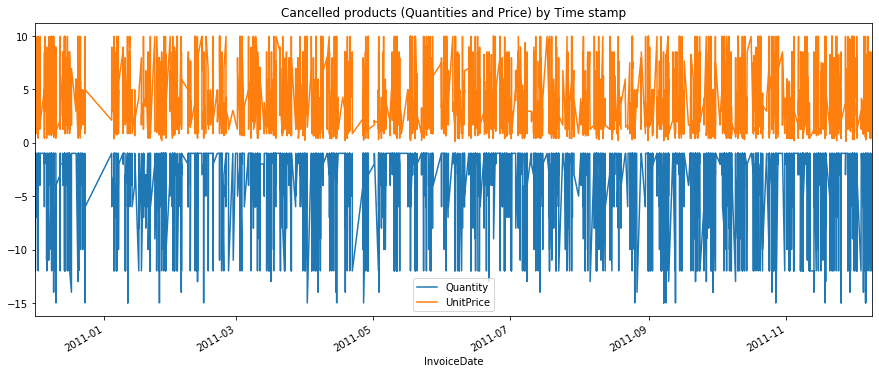

In [73]:
#plotting time series 
_ = time_series.plot(figsize=(15,6))
_ = plt.title('Cancelled products (Quantities and Price) by Time stamp')
plt.show()

The above is noisy and difficult to read. I decided to resample by daily mean and to separate out price and quantity to better attempt to see a trend. 

In [74]:
#creating a series out of quantity values and taking absolute value to create better visualizations
quant_series = time_series['Quantity']
quant_series = quant_series.abs()
type(quant_series)

pandas.core.series.Series

In [75]:
#resampling to the mean of each day
d = quant_series.resample('D').mean()
d.index

DatetimeIndex(['2010-12-01', '2010-12-02', '2010-12-03', '2010-12-04',
               '2010-12-05', '2010-12-06', '2010-12-07', '2010-12-08',
               '2010-12-09', '2010-12-10',
               ...
               '2011-11-30', '2011-12-01', '2011-12-02', '2011-12-03',
               '2011-12-04', '2011-12-05', '2011-12-06', '2011-12-07',
               '2011-12-08', '2011-12-09'],
              dtype='datetime64[ns]', name='InvoiceDate', length=374, freq='D')

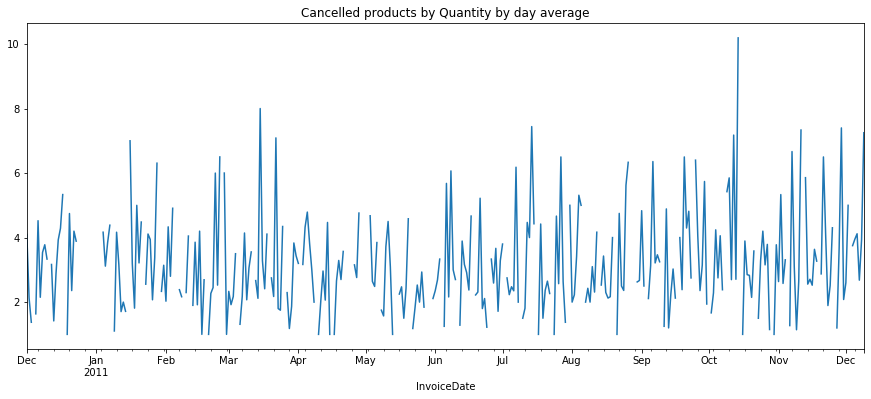

In [76]:
#plotting quantity by day (mean)
_ = d.plot(figsize = (15,6))
_ = plt.title('Cancelled products by Quantity by day average')
plt.show()

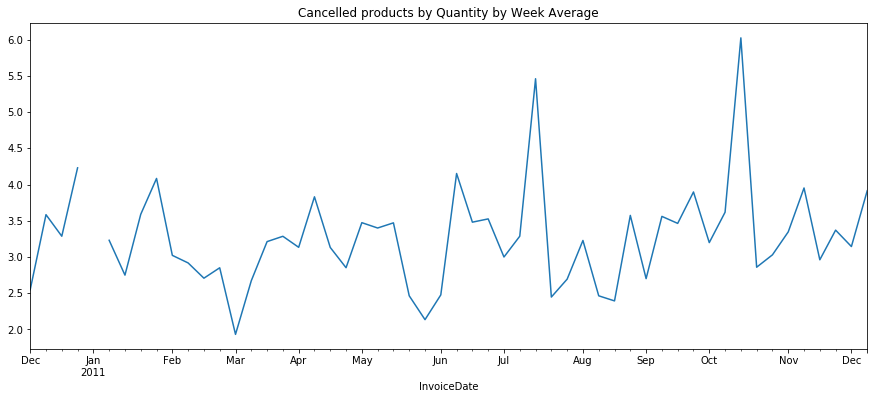

In [77]:
#resampling by week and plot
can_w = quant_series.resample('W').mean()
#plotting quantity by week (mean)
_ = can_w.plot(figsize = (15,6))
_ = plt.title('Cancelled products by Quantity by Week Average')
plt.show()

In [78]:
#finding number of NaN values
can_w.isnull().sum()

1

In [79]:
#dropping NaN value
can_w = can_w.dropna()

First, we must see if the time series is stationary before using it to create a model. Code adapted from: https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

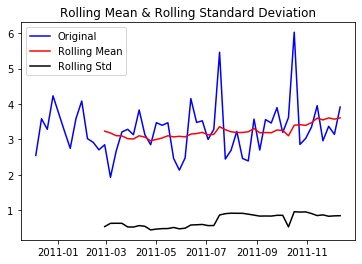

In [80]:
#looking to see if the time series is stationary
rolling_mean = can_w.rolling(window = 12).mean()
rolling_std = can_w.rolling(window = 12).std()
plt.plot(can_w, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [81]:
#rolling mean and rolling standard deviation increase with time, so the time series is not stationary
#now will look at whether this is due to chance
result = adfuller(can_w)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -6.772108287897825
p-value: 2.6259014747500635e-09
Critical Values:
	1%: -3.562878534649522
	5%: -2.918973284023669
	10%: -2.597393446745562


The p-value is well above 0.05 so we can conclude that what we're seeing is not by chance. So, I will subtract the rolling meanto attempt to make the series stationary

In [82]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

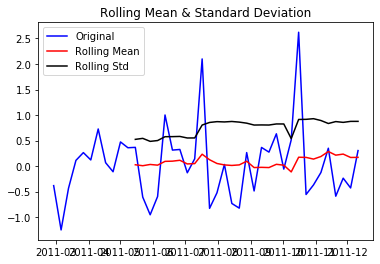

ADF Statistic: -5.9015611137251325
p-value: 2.7702685468880487e-07
Critical Values:
	1%: -3.60098336718852
	5%: -2.9351348158036012
	10%: -2.6059629803688282


In [83]:
rolling_mean = can_w.rolling(window=12).mean()
can_w_minus_mean = can_w - rolling_mean
can_w_minus_mean.dropna(inplace=True)
get_stationarity(can_w_minus_mean)

the p-value actually went up. I next took the log to decrease the rate of change of the rolling mean

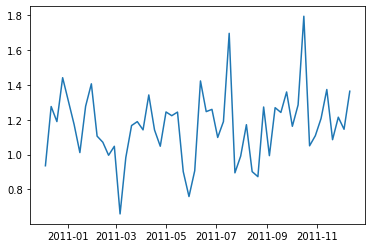

In [189]:
#taking log to decrease rate of rolling mean
can_w_log = np.log(can_w)
plt.plot(can_w_log)

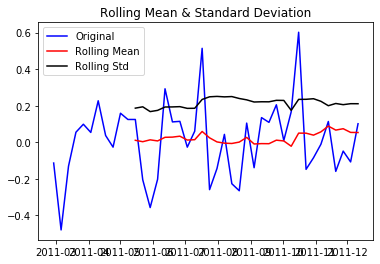

ADF Statistic: -5.470582097376561
p-value: 2.403763833065437e-06
Critical Values:
	1%: -3.60098336718852
	5%: -2.9351348158036012
	10%: -2.6059629803688282


In [190]:
rolling_mean = can_w_log.rolling(window=12).mean()
can_w_log_minus_mean = can_w_log - rolling_mean
can_w_log_minus_mean.dropna(inplace=True)
get_stationarity(can_w_log_minus_mean)

This is an improved p-value but still not low enough to rule out chance. I completed exponential decay next

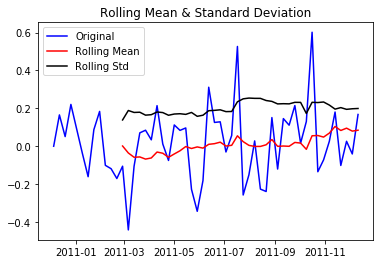

ADF Statistic: -6.337895353473946
p-value: 2.8011641512960815e-08
Critical Values:
	1%: -3.562878534649522
	5%: -2.918973284023669
	10%: -2.597393446745562


In [191]:
rolling_mean_exp_decay = can_w_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
can_w_log_exp_decay = can_w_log - rolling_mean_exp_decay
can_w_log_exp_decay.dropna(inplace=True)
get_stationarity(can_w_log_exp_decay)

This is better than the original but worse than the logarithmic effort. Finally, I complete time shifting to attempt to make the series stationary

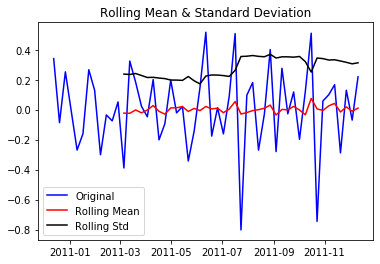

ADF Statistic: -6.014997319772583
p-value: 1.5412290726670986e-07
Critical Values:
	1%: -3.6055648906249997
	5%: -2.937069375
	10%: -2.606985625


In [192]:
can_w_log_shift = can_w_log - can_w_log.shift()
can_w_log_shift.dropna(inplace=True)
get_stationarity(can_w_log_shift)

This performed the best out of all of them, but still does not allow me to rule out chance as a factor

It appears that there is a "valley" in the graph every 3 months or so. Following advice from this source: https://stats.stackexchange.com/questions/285718/seasonal-decomposition
If we assume that there is periodic activity every 3 months, that there is, on average, 4.3 weeks per month, and 1 measurement/week, then the frequency is 12.9. Since seasonal decompose only accepts integers, I rounded to 13 for the frequency parameter. 

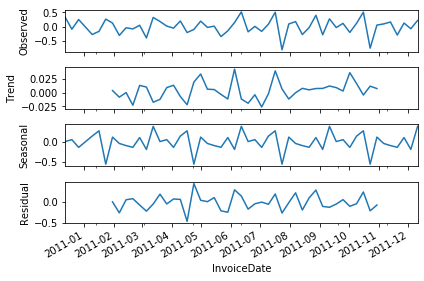

In [193]:
decomp = seasonal_decompose(can_w_log_shift, model='additive', freq=13)
fig = decomp.plot()
plt.show()

Using code from this resource: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/ I created a grid search to find the optimal ARIMA parameters

In [85]:
#evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [194]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(can_w_log_shift.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.083
ARIMA(0, 0, 1) MSE=0.045
ARIMA(0, 0, 2) MSE=0.048
ARIMA(0, 1, 0) MSE=0.251
ARIMA(0, 1, 1) MSE=0.088
ARIMA(0, 2, 0) MSE=0.813
ARIMA(0, 2, 1) MSE=0.263
ARIMA(1, 0, 0) MSE=0.066
ARIMA(1, 1, 0) MSE=0.156
ARIMA(1, 2, 0) MSE=0.468
ARIMA(2, 0, 0) MSE=0.055
ARIMA(2, 0, 1) MSE=0.049
ARIMA(2, 1, 0) MSE=0.111
ARIMA(2, 1, 1) MSE=0.059
ARIMA(2, 2, 0) MSE=0.279
ARIMA(4, 0, 0) MSE=0.061
ARIMA(4, 1, 0) MSE=0.092
ARIMA(4, 1, 1) MSE=0.064
ARIMA(4, 2, 0) MSE=0.168
ARIMA(4, 2, 1) MSE=0.098
ARIMA(6, 0, 0) MSE=0.066
ARIMA(6, 0, 1) MSE=0.057
ARIMA(6, 1, 0) MSE=0.085
ARIMA(8, 0, 0) MSE=0.069
ARIMA(8, 0, 1) MSE=0.052
ARIMA(8, 1, 0) MSE=0.092
ARIMA(10, 0, 0) MSE=0.056
ARIMA(10, 1, 0) MSE=0.086
Best ARIMA(0, 0, 1) MSE=0.045


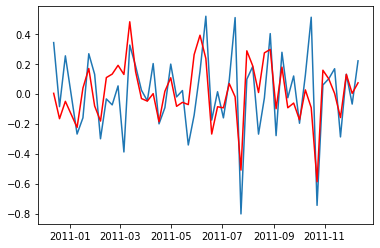

In [195]:
#using best ARIMA parameters from grid search to create model
model = ARIMA(can_w_log_shift, order=(0,0,1))
results = model.fit()
plt.plot(can_w_log_shift)
plt.plot(results.fittedvalues, color='red')

Overall, the prediction lines up with the general peaks and valleys, though it certainly smoothes out the more extreme values. 

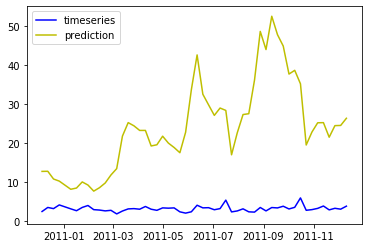

In [198]:
#compare model to original
def model_original(timeseries):
    predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
    predictions_ARIMA = pd.Series(timeseries.iloc[0], index=timeseries.index)
    predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum, fill_value=0)
    predictions_ARIMA = np.exp(predictions_ARIMA)
    plt.plot(timeseries, color='b')
    plt.plot(predictions_ARIMA, color='y')
    labels=['timeseries', 'prediction']
    plt.legend(labels)

model_original(can_w)

Text(0.5, 1.0, 'Predicting 2012 cancellation quantities based on 2011 data')

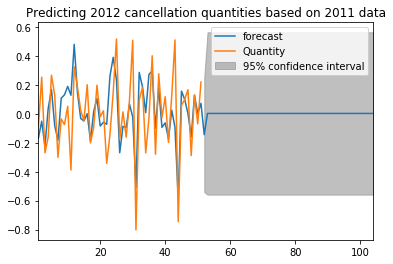

In [199]:
#using 104 as we have 12 months of data  (52 weeks), and I would like to predict the next year (52+52=104 total weeks)
results.plot_predict(1,104)
plt.title('Predicting 2012 cancellation quantities based on 2011 data')

the model seems to follow the general trend of the data well, but doesn't appear to have good predictive power

#### <span style='color:Blue'> cancelled products: price time series analysis  </span>

Quantity is pretty variable, and I wanted to see if price had any clearer trend before moving forward with attempting to model and predict based on quantity.

In [92]:
#creating a series out of UnitPrice values and taking absolute value to create better visualizations
price_series = time_series['UnitPrice']
type(price_series)

pandas.core.series.Series

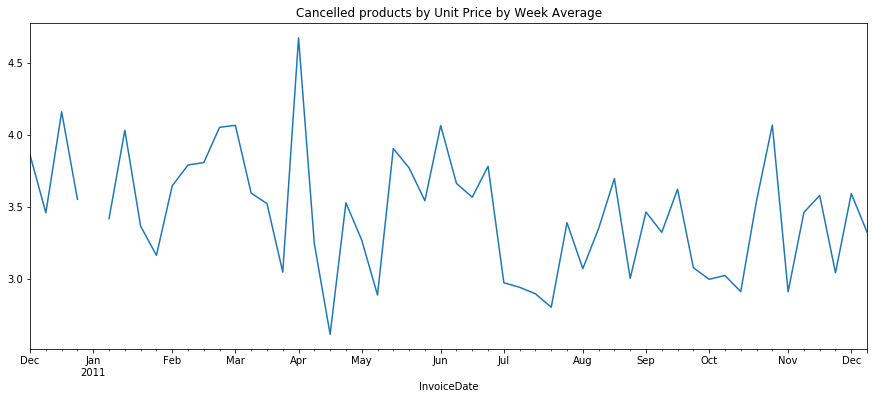

In [93]:
#resampling by week and plot
w_price = price_series.resample('W').mean()
#plotting quantity by day (mean)
_ = w_price.plot(figsize = (15,6))
_ = plt.title('Cancelled products by Unit Price by Week Average')
plt.show()

In [94]:
#dropping NaN value
w_price = w_price.dropna()

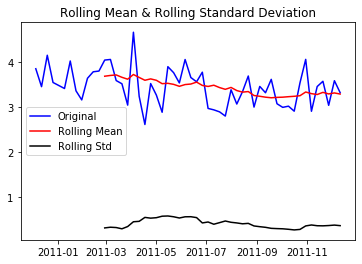

In [95]:
#checking for stationarity
def station_check(timeseries):
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.show()

station_check(w_price)

In [96]:
#checking if variability is due to chance
def by_chance(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

by_chance(w_price)

ADF Statistic: -3.050957513579645
p-value: 0.030401931251921886
Critical Values:
	1%: -3.5714715250448363
	5%: -2.922629480573571
	10%: -2.5993358475635153


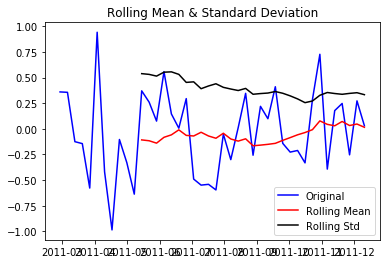

ADF Statistic: -3.1613183416540167
p-value: 0.022335774990256647
Critical Values:
	1%: -3.6155091011809297
	5%: -2.941262357486514
	10%: -2.6091995013850418


In [97]:
#p-value just over statistical significance line, so will flatten out rolling mean and std
rolling_mean = w_price.rolling(window=12).mean()
w_price_minus_mean = w_price - rolling_mean
w_price_minus_mean.dropna(inplace=True)
get_stationarity(w_price_minus_mean)

This has an improved p-value to indicate that the time series is now stationary

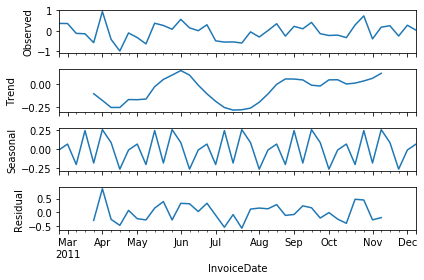

In [98]:
#decomposing times series into trend, seasonality, and noise
#frequency of 8 or 9 due to approximate period of valleys every 2 months in plot above
decomp_1 = seasonal_decompose(w_price_minus_mean, model='additive', freq=8)
fig = decomp_1.plot()
plt.show()

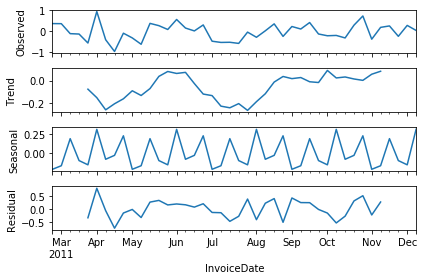

In [99]:
decomp_2 = seasonal_decompose(w_price_minus_mean, model='additive', freq=9)
fig = decomp_2.plot()
plt.show()

The trend is remarkably similar for both frequencies, so moving forward I will utilize decomp_1

In [100]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(w_price_minus_mean.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.111
ARIMA(0, 0, 1) MSE=0.116
ARIMA(0, 0, 2) MSE=0.122
ARIMA(0, 1, 0) MSE=0.235
ARIMA(0, 1, 1) MSE=0.123
ARIMA(0, 2, 0) MSE=0.744
ARIMA(0, 2, 1) MSE=0.249
ARIMA(1, 0, 0) MSE=0.115
ARIMA(1, 0, 1) MSE=0.116
ARIMA(1, 1, 0) MSE=0.178
ARIMA(1, 1, 1) MSE=0.128
ARIMA(1, 1, 2) MSE=0.128
ARIMA(1, 2, 0) MSE=0.433
ARIMA(2, 0, 0) MSE=0.118
ARIMA(2, 1, 0) MSE=0.142
ARIMA(2, 1, 1) MSE=0.146
ARIMA(2, 1, 2) MSE=0.147
ARIMA(2, 2, 0) MSE=0.242
ARIMA(2, 2, 1) MSE=0.161
ARIMA(4, 0, 0) MSE=0.113
ARIMA(4, 1, 0) MSE=0.143
ARIMA(4, 2, 0) MSE=0.228
ARIMA(4, 2, 1) MSE=0.170
ARIMA(4, 2, 2) MSE=0.249
ARIMA(6, 0, 0) MSE=0.147
ARIMA(6, 0, 1) MSE=0.195
ARIMA(6, 1, 0) MSE=0.151
ARIMA(6, 2, 1) MSE=0.176
ARIMA(8, 0, 0) MSE=0.155
ARIMA(8, 0, 1) MSE=0.206
ARIMA(8, 1, 0) MSE=0.199
ARIMA(8, 2, 2) MSE=0.403
ARIMA(10, 1, 0) MSE=0.171
Best ARIMA(0, 0, 0) MSE=0.111


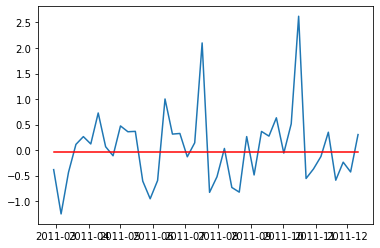

In [104]:
#using best ARIMA parameters from grid search to create model. I chose an equally good parameter setting
model = ARIMA(w_price_minus_mean, order=(0,0,0))
results = model.fit()
plt.plot(can_w_minus_mean)
plt.plot(results.fittedvalues, color='red')

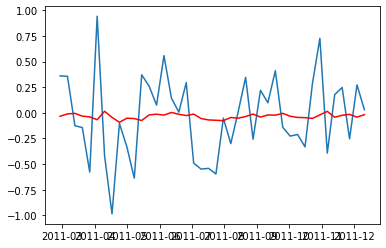

In [102]:
#allowing for increased MSE, I ran an ARIMA with parameters (1,0,1) with MSE=0.009
model = ARIMA(w_price_minus_mean, order=(1,0,1))
results = model.fit()
plt.plot(w_price_minus_mean)
plt.plot(results.fittedvalues, color='red')

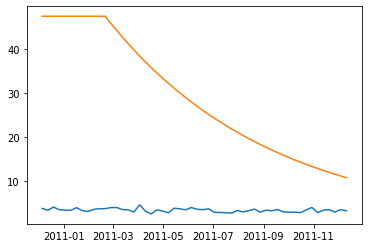

In [105]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA = pd.Series(w_price.iloc[0], index=w_price.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA)
plt.plot(w_price)
plt.plot(predictions_ARIMA)

The model doesn't appear to match the original data particularly well

Text(0.5, 1.0, 'Price predictions for 2012, based on 2011')

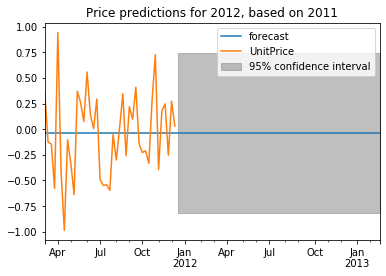

In [106]:
#using 104 as we have 12 months of data  (52 weeks), and I would like to predict the next year (52+52=104 total weeks)
results.plot_predict(1,104)
plt.title("Price predictions for 2012, based on 2011")

Hardly a convincing model, as the 95% confidence interval spans the entire range of the data. 

#### <span style='color:Blue'> Conclusion: for cancelled products, both quantity and price are highly variable and difficult to predict over time. Would benefit from more data over more time to better make predictions about the future.  </span>

## <span style='color:Blue'> Purchased products analysis  </span>

In addition to cancelled orders, I wanted to look at which products are most and least commonly purchased. I started by removing the cancelled products from the retail dataframe to avoid including these products. 

In [107]:
purchased = retail.drop(retail[retail['InvoiceNo'].str.contains('C', na=False)].index)
purchased.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Weekday,WeekdayNum,DateSec,CountryNum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Wednesday,2,1291191960000000000,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Wednesday,2,1291191960000000000,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Wednesday,2,1291191960000000000,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Wednesday,2,1291191960000000000,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Wednesday,2,1291191960000000000,0


In [108]:
purchased.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532621 entries, 0 to 541908
Data columns (total 12 columns):
InvoiceNo      532621 non-null object
StockCode      532621 non-null object
Description    531167 non-null object
Quantity       532621 non-null int64
InvoiceDate    532621 non-null datetime64[ns]
UnitPrice      532621 non-null float64
CustomerID     397924 non-null float64
Country        532621 non-null object
Weekday        532621 non-null object
WeekdayNum     532621 non-null int64
DateSec        532621 non-null int64
CountryNum     532621 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 52.8+ MB


quick math from the original retail dataframe number of entries minus cancelled dataframe number of entries shows me that this dataframe has the expected number of entries. 

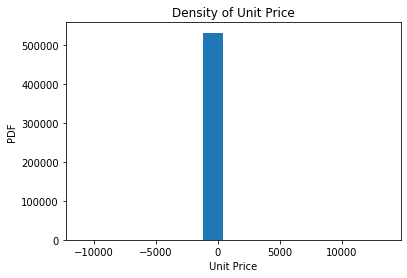

In [109]:
#check if prices of products in purchased data to check for normalcy 
_ = plt.hist(purchased['UnitPrice'], bins=15)
_ = plt.xlabel("Unit Price")
_ = plt.ylabel("PDF")
_ = plt.title("Density of Unit Price")
plt.show()

I noticed in the above that the unit price seemed to skew negative, even though I should have removed all the negative numbers (which would have corresponded to cancelled invoices). I looked for unit prices below 0 and found the following:

In [110]:
negative = purchased.loc[purchased['UnitPrice'] < 0]
negative

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Weekday,WeekdayNum,DateSec,CountryNum
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,Friday,4,1313160660000000000,0
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,Friday,4,1313160720000000000,0


Difficult to say what this product description is referring to. This would definitely be something I would ask the client about to better understand what this is referring to and how it relates to the work I am attempting. 

I wanted to make sure these were outliers, so I created a box plot and calculated the z-scores. 

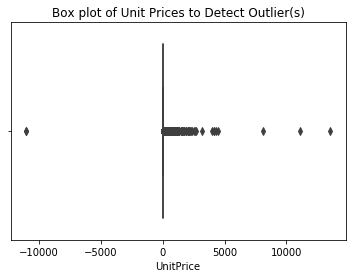

In [111]:
_ = sns.boxplot(x=purchased['UnitPrice'])
_ = plt.title('Box plot of Unit Prices to Detect Outlier(s)')
plt.show()

There certainly seems to be an outlier at around -10,000, which I suspected. There also seem to be at least 3 points on the high end that may be outliers as well. I looked for these and found that there is a similar charge that would negate the "adjust bad credit" on the negative end as well as an Amazon fee and postage which don't really correspond to product prices.

In [112]:
high = purchased.loc[purchased['UnitPrice'] > 5000]
high

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Weekday,WeekdayNum,DateSec,CountryNum
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom,Tuesday,1,1291734480000000000,0
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,Tuesday,1,1304430360000000000,0
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,Friday,4,1313160600000000000,0


Looking at which data points have a z-score of greater than -3 or 3 (which would indicate outliers), we get the following:

In [113]:
z = np.abs(stats.zscore(purchased['UnitPrice']))
print(np.where(z > 3))
print("Outliers: ", len(z))

(array([   237,   1802,   3015,   4919,   5370,   5605,   6085,  10710,
        11279,  13775,  14238,  14839,  15472,  15701,  15807,  15931,
        16053,  16595,  18324,  19193,  19194,  21045,  21621,  21734,
        21860,  22788,  24536,  24771,  26857,  27506,  30352,  30405,
        30471,  31936,  34206,  35050,  35566,  35865,  36471,  37645,
        38129,  38655,  39086,  39205,  39602,  39680,  39790,  39883,
        39957,  39998,  40151,  40203,  40739,  41331,  42246,  43342,
        44378,  45526,  46917,  47543,  49823,  50487,  50706,  50958,
        52197,  52610,  53653,  53857,  54588,  54836,  55495,  56064,
        56108,  56856,  59341,  59531,  59909,  60243,  61399,  61572,
        61858,  62923,  64336,  64789,  65540,  65578,  65847,  66350,
        67350,  67702,  68103,  68765,  69016,  70120,  71270,  71316,
        72022,  72170,  73674,  74859,  75010,  75075,  75577,  77502,
        78157,  78158,  78263,  78563,  79484,  80230,  80272,  80512,
     

I do notice that this suggests every data point in the purchased data frame is an outlier, which doesn't seem particularly accurate. 

This will be addressed after I remove the stock codes that don't correspond to products.

We learned beforehand that postage, Amazon fees, and adjust bad debt were included in the purchased dataframe and perhaps should not have been. I looked at these items (commented out for space saving) and removed them from my data frame to get a better look at the products only.

I later found that dotcom postage and "Manual" was also included in this list and added it to the rows that I would drop.

In [114]:
#purchased.loc[purchased['StockCode'] == 'POST']

In [115]:
#purchased.loc[purchased['StockCode'] == 'AMAZONFEE']

In [116]:
#purchased.loc[purchased['StockCode'] == 'B']

In [117]:
purchased.drop(purchased[purchased['StockCode'] == 'POST'].index, inplace=True)
purchased.drop(purchased[purchased['StockCode'] == 'AMAZONFEE'].index, inplace=True)
purchased.drop(purchased[purchased['StockCode'] == 'B'].index, inplace=True)
purchased.drop(purchased[purchased['StockCode'] == 'DOT'].index, inplace=True)
purchased.drop(purchased[purchased['StockCode'] == 'M'].index, inplace=True)

In [118]:
#new outlier calculation
new_outlier = np.abs(stats.zscore(purchased['UnitPrice']))
print(np.where(new_outlier > 3))
print("New outliers: ", len(new_outlier))

(array([   151,    165,    236, ..., 530028, 530076, 530082], dtype=int64),)
New outliers:  530450


 This removed around 2200 data points, but will likely be closer to giving information only on the products, rather than other fees or whatever is occuring with the bad debt adjustment. I then created a box plot as before as well as a box plot using a log scale to attempt to better visualize the data and potential outliers. 

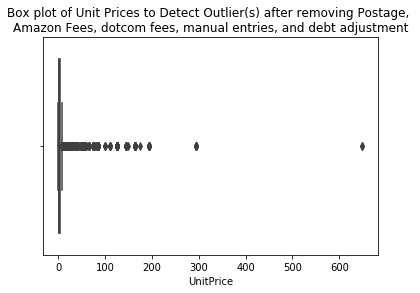

In [119]:
_ = sns.boxplot(x=purchased['UnitPrice'])
_ = plt.title('Box plot of Unit Prices to Detect Outlier(s) after removing Postage, \nAmazon Fees, dotcom fees, manual entries, and debt adjustment')
plt.show()

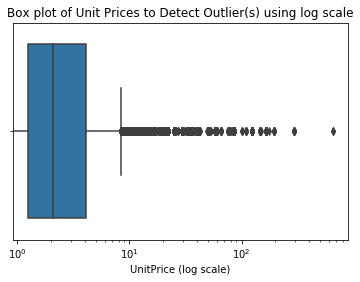

In [120]:
f, ax = plt.subplots()
sns.boxplot(x=purchased['UnitPrice'])
ax.set_xscale('log')
plt.xlabel('UnitPrice (log scale)')
plt.title('Box plot of Unit Prices to Detect Outlier(s) using log scale')
plt.show()

From this graph, it would appear that statistically, most of the proucts lie in the 0-10 Pound range. If we only looked at these products, we would still have over 500,000 products in our dataframe

In [121]:
normal = purchased.loc[purchased['UnitPrice'] < 10]
normal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508389 entries, 0 to 541908
Data columns (total 12 columns):
InvoiceNo      508389 non-null object
StockCode      508389 non-null object
Description    506940 non-null object
Quantity       508389 non-null int64
InvoiceDate    508389 non-null datetime64[ns]
UnitPrice      508389 non-null float64
CustomerID     386824 non-null float64
Country        508389 non-null object
Weekday        508389 non-null object
WeekdayNum     508389 non-null int64
DateSec        508389 non-null int64
CountryNum     508389 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 50.4+ MB


A histogram of this data (those unit prices less than 10) yields the following plot, which is still right tailed. This means that my data will likely be skewed high, even after taking into account and removing some of the higher items, like postage, fees, debt adjustments, and manual entries.  

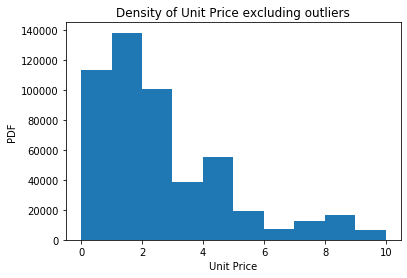

In [122]:
_ = plt.hist(normal['UnitPrice'])
_ = plt.xlabel("Unit Price")
_ = plt.ylabel("PDF")
_ = plt.title("Density of Unit Price excluding outliers")
plt.show()

I also checked to see if the quantity was normally distributed (as I did above for cancelled products)

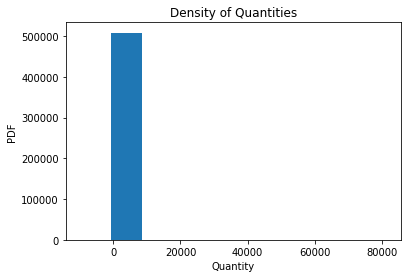

In [123]:
_ = plt.hist(normal['Quantity'])
_ = plt.xlabel('Quantity')
_ = plt.ylabel("PDF")
_ = plt.title("Density of Quantities")
plt.show()

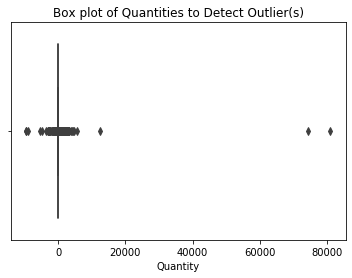

In [124]:
_ = sns.boxplot(x=normal['Quantity'])
_ = plt.title('Box plot of Quantities to Detect Outlier(s)')
plt.show()

In [125]:
#checking for negative numbers, as purchased quantities should be positive numbers
normal.loc[normal['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Weekday,WeekdayNum,DateSec,CountryNum
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom,Wednesday,2,1291222200000000000,0
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom,Thursday,3,1291300920000000000,0
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,Friday,4,1291390200000000000,0
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,Friday,4,1291390200000000000,0
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom,Friday,4,1291390200000000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom,Wednesday,2,1323282960000000000,0
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom,Wednesday,2,1323283080000000000,0
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom,Wednesday,2,1323283080000000000,0
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom,Thursday,3,1323338160000000000,0


In [126]:
#removing negative numbers and rechecking boxplot with log scale
normal.drop(normal[normal['Quantity'] < 0].index, inplace=True)
normal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507053 entries, 0 to 541908
Data columns (total 12 columns):
InvoiceNo      507053 non-null object
StockCode      507053 non-null object
Description    506466 non-null object
Quantity       507053 non-null int64
InvoiceDate    507053 non-null datetime64[ns]
UnitPrice      507053 non-null float64
CustomerID     386824 non-null float64
Country        507053 non-null object
Weekday        507053 non-null object
WeekdayNum     507053 non-null int64
DateSec        507053 non-null int64
CountryNum     507053 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 50.3+ MB


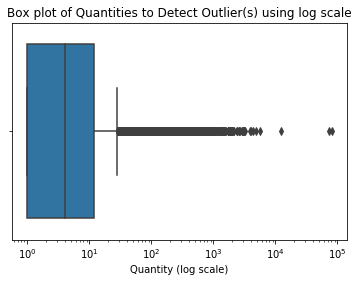

In [127]:
#boxplot with log scale
f, ax = plt.subplots()
sns.boxplot(x=normal['Quantity'])
ax.set_xscale('log')
plt.xlabel('Quantity (log scale)')
plt.title('Box plot of Quantities to Detect Outlier(s) using log scale')
plt.show()

It would appear that quantities above approximately 19 are outliers, so I will remove those

In [128]:
#dropping quantities above 19
normal.drop(normal[normal['Quantity'] > 19].index, inplace=True)

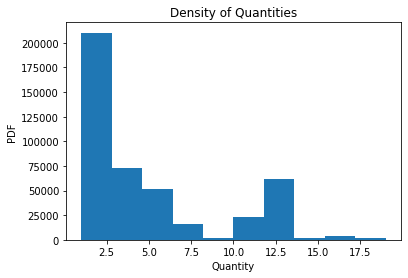

In [129]:
#new histogram with outliers removed
_ = plt.hist(normal['Quantity'])
_ = plt.xlabel('Quantity')
_ = plt.ylabel("PDF")
_ = plt.title("Density of Quantities")
plt.show()

I looked next at the day of the week that products were purchased on. This is similar to the work I did for cancelled products above. 

Again, there were no purchased products on Saturday. Perhaps the store is closed on Saturdays?

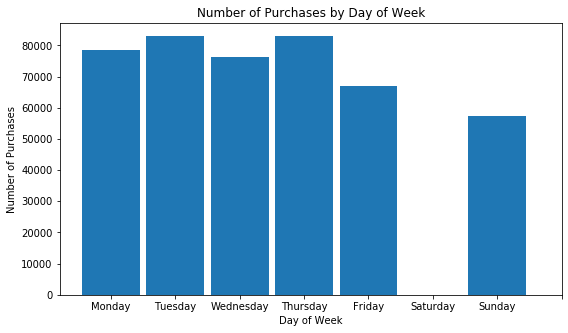

In [130]:
weekday_int = [0,1,2,3,4,5,6,7]
_ = plt.figure(figsize=[9,5])
_ = plt.hist(normal['WeekdayNum'], bins=weekday_int, align='left', rwidth=0.9)
_ = plt.xticks(ticks=weekday_int, labels=days_of_week)
_ = plt.xlabel('Day of Week')
_ = plt.ylabel('Number of Purchases')
_ = plt.title('Number of Purchases by Day of Week')
plt.show()

In [131]:
normal.loc[normal['Weekday'] =='Saturday']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Weekday,WeekdayNum,DateSec,CountryNum


In [132]:
monday = normal['Weekday'] =='Monday'
tuesday = normal['Weekday'] =='Tuesday'
wednesday = normal['Weekday'] =='Wednesday'
thursday = normal['Weekday'] =='Thursday'
friday = normal['Weekday'] =='Friday'
saturday = normal['Weekday'] =='Saturday'
sunday = normal['Weekday'] =='Sunday'

In [133]:
print('ANOVA for all days of week for purchased products:', stats.f_oneway(monday, tuesday, wednesday, thursday, friday, saturday, sunday))

ANOVA for all days of week for purchased products: F_onewayResult(statistic=16525.841927335536, pvalue=0.0)


The ANOVA suggests that there the variance we see is not due to chance. 

<span style='color:Blue'> k-means clustering for purchased products  </span>

I completed a KMeans clustering for the purchased products as well

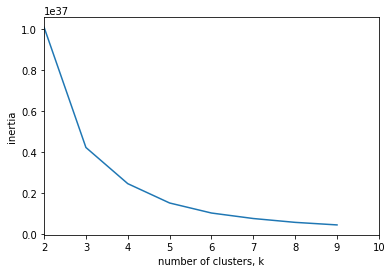

In [134]:
x_cols = list(normal[['Quantity', 'UnitPrice', 'WeekdayNum', 'DateSec', 'CountryNum']])

data = normal[x_cols]

#re-determining optimal k-value
ks = range(2,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(data)
    inertias.append(model.inertia_)
    

_ = plt.plot(ks, inertias)
_ = plt.xlim(2,10)
_ = plt.xlabel('number of clusters, k')
_ = plt.ylabel('inertia')
plt.show()

445255


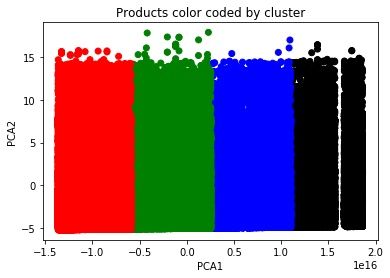

In [135]:
x_cols = list(normal[['Quantity', 'UnitPrice', 'WeekdayNum', 'DateSec', 'CountryNum']])
data = normal[x_cols]

X = np.array(data)

model = KMeans(n_clusters=4)
cluster_assignments = model.fit_predict(X)


print(len(cluster_assignments))
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue', 'black'])

pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
_ = plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)
_ = plt.xlabel('PCA1')
_ = plt.ylabel('PCA2')
_ = plt.title('Products color coded by cluster')
plt.show()

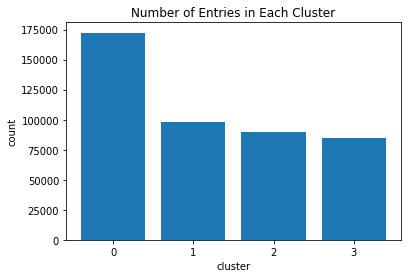

In [136]:
#plotting number of entries in each cluster
num_count = pd.Series.value_counts(cluster_assignments)

_ = plt.bar(x=num_count.index, height=num_count)
_ = plt.xlabel('cluster')
_ = plt.xticks(np.arange(0,4, 1))
_ = plt.ylabel('count')
_ = plt.title('Number of Entries in Each Cluster')
plt.show()

In [137]:
purchased_0 = data[cluster_assignments ==0]
purchased_0.describe()

,Quantity,UnitPrice,WeekdayNum,DateSec,CountryNum
count,172395.000000,172395.000000,172395.000000,1.723950e+05,172395.000000
mean,4.680849,2.801338,2.536431,1.320068e+18,0.460077
std,4.182577,2.146837,1.928833,2.222947e+15,2.361821
min,1.000000,0.000000,0.000000,1.315737e+18,0.000000
25%,1.000000,1.250000,1.000000,1.318246e+18,0.000000
50%,3.000000,2.080000,2.000000,1.320410e+18,0.000000
75%,6.000000,3.750000,4.000000,1.321976e+18,0.000000
max,19.000000,9.980000,6.000000,1.323435e+18,37.000000


In [138]:
purchased_1 = data[cluster_assignments ==1]
purchased_1.describe()

,Quantity,UnitPrice,WeekdayNum,DateSec,CountryNum
count,97979.000000,97979.000000,97979.000000,9.797900e+04,97979.000000
mean,4.863236,2.842460,2.459190,1.311379e+18,0.717562
std,4.251111,2.196864,1.856498,2.487698e+15,3.351500
min,1.000000,0.000000,0.000000,1.307269e+18,0.000000
25%,1.000000,1.250000,1.000000,1.309352e+18,0.000000
50%,3.000000,2.080000,2.000000,1.311179e+18,0.000000
75%,8.000000,4.130000,4.000000,1.313586e+18,0.000000
max,19.000000,9.980000,6.000000,1.315591e+18,36.000000


In [139]:
purchased_2 = data[cluster_assignments ==2]
purchased_2.describe()

,Quantity,UnitPrice,WeekdayNum,DateSec,CountryNum
count,89760.000000,89760.000000,89760.000000,8.976000e+04,89760.000000
mean,4.806139,2.996565,2.390675,1.302938e+18,0.506484
std,4.197637,2.294374,1.847104,2.426116e+15,2.590800
min,1.000000,0.000000,0.000000,1.298801e+18,0.000000
25%,1.000000,1.250000,1.000000,1.300810e+18,0.000000
50%,3.000000,2.100000,2.000000,1.302864e+18,0.000000
75%,8.000000,4.130000,4.000000,1.305117e+18,0.000000
max,19.000000,9.980000,6.000000,1.307121e+18,35.000000


In [140]:
purchased_3 = data[cluster_assignments ==3]
purchased_3.describe()

,Quantity,UnitPrice,WeekdayNum,DateSec,CountryNum
count,85121.000000,85121.000000,85121.000000,8.512100e+04,85121.000000
mean,4.290222,3.103820,2.391842,1.294479e+18,0.396588
std,4.011825,2.260608,1.820636,2.358501e+15,2.106827
min,1.000000,0.000000,0.000000,1.291192e+18,0.000000
25%,1.000000,1.450000,1.000000,1.292001e+18,0.000000
50%,2.000000,2.510000,2.000000,1.294670e+18,0.000000
75%,6.000000,4.210000,4.000000,1.296474e+18,0.000000
max,19.000000,9.980000,6.000000,1.298655e+18,29.000000


As before, the clustering algorithm seems to have divided these into date chunks and there are no other discernable differences between the clusters. 

I re-clustered without the date

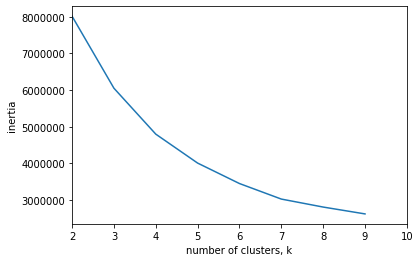

In [141]:
x_cols = list(normal[['Quantity', 'UnitPrice', 'WeekdayNum', 'CountryNum']])

data = normal[x_cols]

#re-determining optimal k-value
ks = range(2,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(data)
    inertias.append(model.inertia_)
    

_ = plt.plot(ks, inertias)
_ = plt.xlim(2,10)
_ = plt.xlabel('number of clusters, k')
_ = plt.ylabel('inertia')
plt.show()

There isn't an obvious elbow to this plot, so I first selected 4. This yielded a very messy plot, so I tried again with 2. 

445255


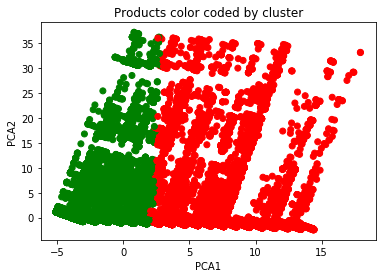

In [142]:
X = np.array(data)

model = KMeans(n_clusters=2)
cluster_assignments = model.fit_predict(X)


print(len(cluster_assignments))
cmap = matplotlib.colors.ListedColormap(['red', 'green'])

pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
_ = plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)
_ = plt.xlabel('PCA1')
_ = plt.ylabel('PCA2')
_ = plt.title('Products color coded by cluster')
plt.show()

This does not appear to be a particularly convincing clustering, as there is a lot of apparent intersection between the two clusters. So, again, I looked at a time series by quantity and price to hopefully see a predictable pattern. 

#### <span style='color:Blue'> purchased products time series analysis </span>

In [143]:
#grouping cancelled dataframe by InvoiceDate to create a series of the time series values
purch_times = normal.set_index('InvoiceDate')
purch_times.index

DatetimeIndex(['2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:28:00',
               '2010-12-01 08:28:00', '2010-12-01 08:34:00',
               ...
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00'],
              dtype='datetime64[ns]', name='InvoiceDate', length=445255, freq=None)

In [144]:
#creating a new data frame with only quantity and price
purch_times = purch_times[['Quantity', 'UnitPrice']].copy()
purch_times.head()

,Quantity,UnitPrice
InvoiceDate,,
2010-12-01 08:26:00,6,2.55
2010-12-01 08:26:00,6,3.39
2010-12-01 08:26:00,8,2.75
2010-12-01 08:26:00,6,3.39
2010-12-01 08:26:00,6,3.39


In [145]:
#creating a series out of quantity values and taking absolute value to create better visualizations
purch_quant = purch_times['Quantity']
type(purch_quant)

pandas.core.series.Series

In [146]:
#resampling to the mean of each day
d = purch_quant.resample('D').mean()
d.index

DatetimeIndex(['2010-12-01', '2010-12-02', '2010-12-03', '2010-12-04',
               '2010-12-05', '2010-12-06', '2010-12-07', '2010-12-08',
               '2010-12-09', '2010-12-10',
               ...
               '2011-11-30', '2011-12-01', '2011-12-02', '2011-12-03',
               '2011-12-04', '2011-12-05', '2011-12-06', '2011-12-07',
               '2011-12-08', '2011-12-09'],
              dtype='datetime64[ns]', name='InvoiceDate', length=374, freq='D')

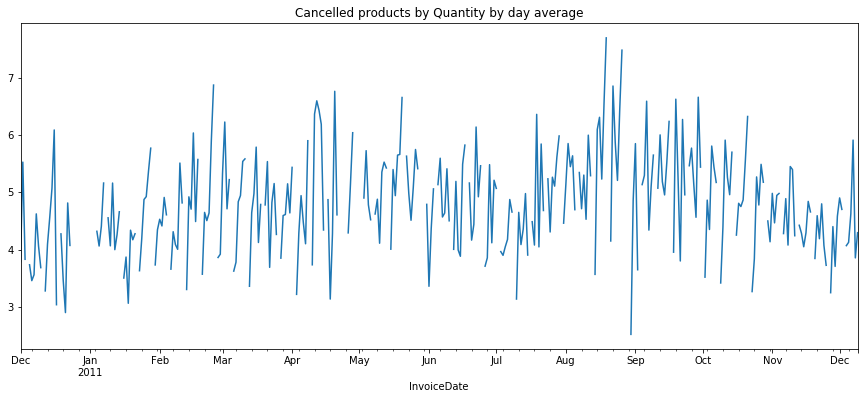

In [147]:
#plotting quantity by day (mean)
_ = d.plot(figsize = (15,6))
_ = plt.title('Cancelled products by Quantity by day average')
plt.show()

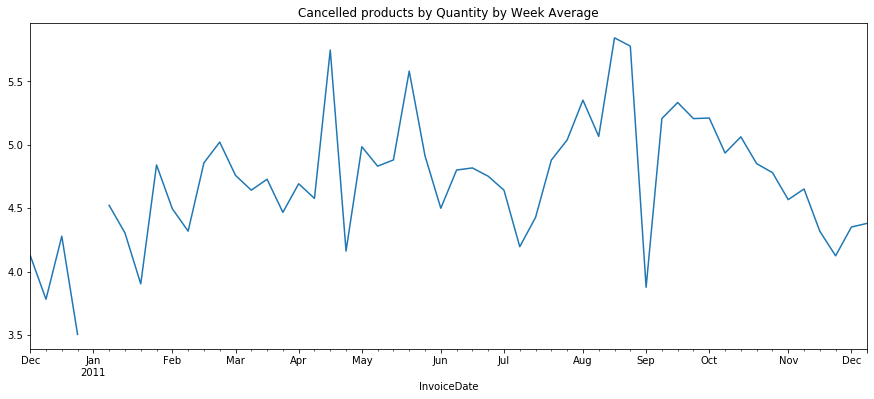

In [148]:
#resampling by week and plot
pur_w = purch_quant.resample('W').mean()
#plotting quantity by week (mean)
_ = pur_w.plot(figsize = (15,6))
_ = plt.title('Cancelled products by Quantity by Week Average')
plt.show()

In [149]:
#dropping NaN value
pur_w = pur_w.dropna()

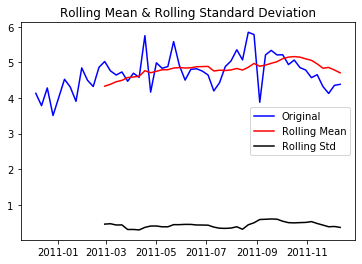

In [150]:
#checking stationarity
station_check(pur_w)

In [151]:
#variability by chance?
by_chance(pur_w)

ADF Statistic: -5.079743524716554
p-value: 1.53951596089334e-05
Critical Values:
	1%: -3.562878534649522
	5%: -2.918973284023669
	10%: -2.597393446745562


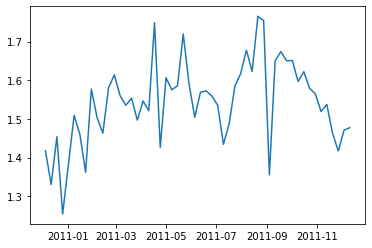

In [152]:
#taking log to decrease rate of rolling mean
pur_w_log = np.log(pur_w)
plt.plot(pur_w_log)

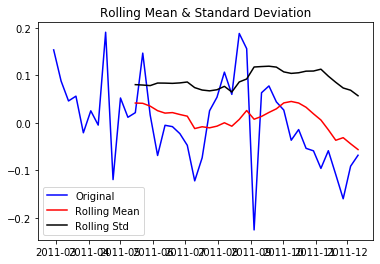

ADF Statistic: -5.054069654364699
p-value: 1.7327753214974155e-05
Critical Values:
	1%: -3.60098336718852
	5%: -2.9351348158036012
	10%: -2.6059629803688282


In [153]:
rolling_mean = pur_w_log.rolling(window=12).mean()
pur_w_log_minus_mean = pur_w_log - rolling_mean
pur_w_log_minus_mean.dropna(inplace=True)
get_stationarity(pur_w_log_minus_mean)

After attempting to make the time series more stationary, I seem to have made it worse, increasing the p-value. So, I applied exponential decay to see if that worked

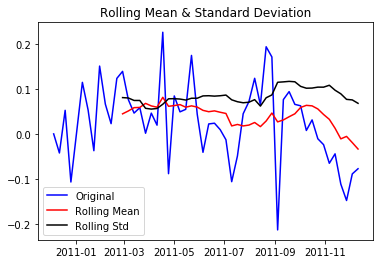

ADF Statistic: -5.873767500206594
p-value: 3.194866390280721e-07
Critical Values:
	1%: -3.562878534649522
	5%: -2.918973284023669
	10%: -2.597393446745562


In [154]:
rolling_mean_exp_decay = pur_w_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
pur_w_log_exp_decay = pur_w_log - rolling_mean_exp_decay
pur_w_log_exp_decay.dropna(inplace=True)
get_stationarity(pur_w_log_exp_decay)

This performed even more poorly than the original effort. I next tried time shifting

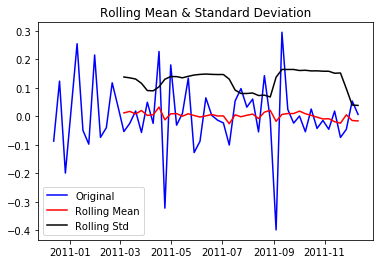

ADF Statistic: -9.155965100042273
p-value: 2.6094287713526205e-15
Critical Values:
	1%: -3.568485864
	5%: -2.92135992
	10%: -2.5986616


In [155]:
pur_w_log_shift = pur_w_log - pur_w_log.shift()
pur_w_log_shift.dropna(inplace=True)
get_stationarity(pur_w_log_shift)

time shifting performed better than exponential decay but still worse than subtracting the rolling mean. In fact, the best one was the original data. 

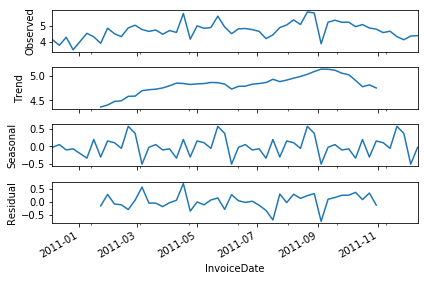

In [156]:
#decomposing times series into trend, seasonality, and noise
#freq parameter of 13 due to valleys every 2-3 months. 
decomp = seasonal_decompose(pur_w, model='additive', freq=13)
fig = decomp.plot()
plt.show()

In [157]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(pur_w.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.326
ARIMA(0, 0, 1) MSE=0.294
ARIMA(0, 0, 2) MSE=0.324
ARIMA(0, 1, 0) MSE=0.358
ARIMA(0, 1, 1) MSE=0.277
ARIMA(0, 2, 0) MSE=0.999
ARIMA(0, 2, 1) MSE=0.377
ARIMA(1, 0, 0) MSE=0.288
ARIMA(1, 1, 0) MSE=0.317
ARIMA(1, 1, 1) MSE=0.336
ARIMA(1, 1, 2) MSE=0.482
ARIMA(1, 2, 0) MSE=0.746
ARIMA(2, 0, 0) MSE=0.300
ARIMA(2, 0, 1) MSE=0.340
ARIMA(2, 1, 0) MSE=0.278
ARIMA(2, 1, 1) MSE=0.350
ARIMA(2, 1, 2) MSE=0.333
ARIMA(2, 2, 0) MSE=0.498
ARIMA(4, 0, 0) MSE=0.286
ARIMA(4, 0, 1) MSE=0.282
ARIMA(4, 1, 0) MSE=0.289
ARIMA(4, 1, 1) MSE=0.348
ARIMA(4, 1, 2) MSE=0.309
ARIMA(4, 2, 0) MSE=0.349
ARIMA(4, 2, 1) MSE=0.310
ARIMA(6, 0, 0) MSE=0.299
ARIMA(6, 0, 1) MSE=0.318
ARIMA(6, 1, 0) MSE=0.328
ARIMA(6, 1, 1) MSE=0.368
ARIMA(8, 0, 0) MSE=0.350
ARIMA(8, 0, 1) MSE=0.352
ARIMA(8, 1, 0) MSE=0.373
Best ARIMA(0, 1, 1) MSE=0.277


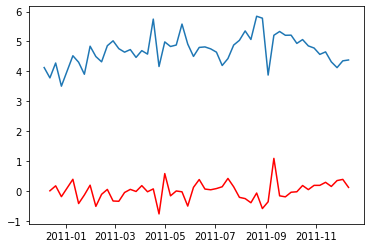

In [158]:
#using best ARIMA parameters from grid search to create model.
model = ARIMA(pur_w, order=(0,1,1))
results = model.fit()
plt.plot(pur_w)
plt.plot(results.fittedvalues, color='red')

This didn't visually look right to me, even though my grid search was telling me that these were the best parameters. I elected to choose a slightly higher MSE to see if the model fit any better. 

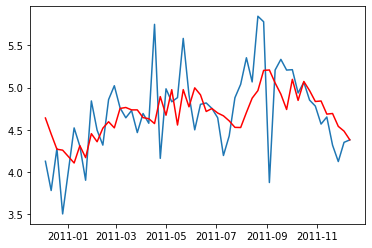

In [159]:
#using ARIMA parameters (6,0,0) MSE=0.299
model = ARIMA(pur_w, order=(6,0,0))
results = model.fit()
plt.plot(pur_w)
plt.plot(results.fittedvalues, color='red')

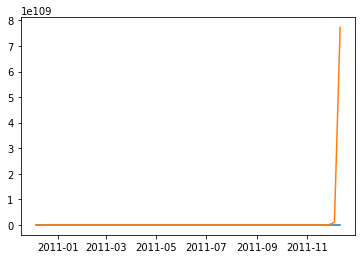

In [160]:
model_original(pur_w)

Text(0.5, 1.0, 'Quantity predictions for purchased products for 2012, based on 2011')

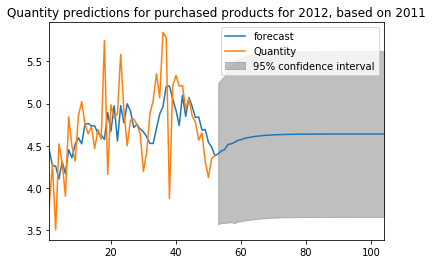

In [161]:
#using 104 as we have 12 months of data  (52 weeks), and I would like to predict the next year (52+52=104 total weeks)
results.plot_predict(1,104)
plt.title("Quantity predictions for purchased products for 2012, based on 2011")

Once again, not a compelling model as the 95% confidence interval around the forecast is so wide

#### <span style='color:Blue'> purchased products: price time series analysis  </span>

In [162]:
#creating a series out of UnitPrice values and taking absolute value to create better visualizations
purch_price = purch_times['UnitPrice']
type(purch_price)

pandas.core.series.Series

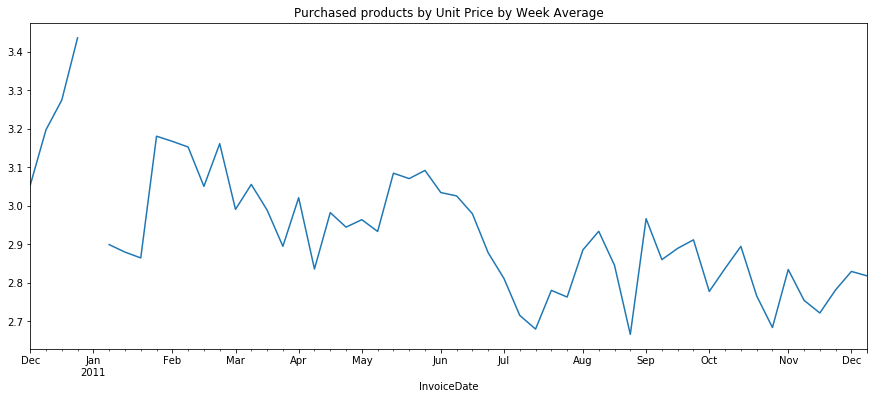

In [163]:
#resampling by week and plot
pur_price = purch_price.resample('W').mean()
#plotting quantity by day (mean)
_ = pur_price.plot(figsize = (15,6))
_ = plt.title('Purchased products by Unit Price by Week Average')
plt.show()

In [164]:
#dropping NaN value
pur_price = pur_price.dropna()

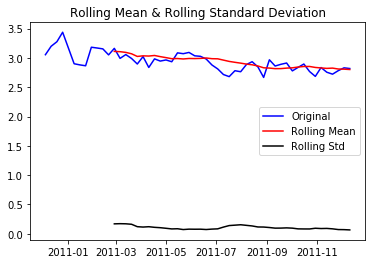

In [165]:
station_check(pur_price)

In [166]:
by_chance(pur_price)

ADF Statistic: -2.6547060445998927
p-value: 0.08220934640029198
Critical Values:
	1%: -3.5656240522121956
	5%: -2.920142229157715
	10%: -2.598014675124952


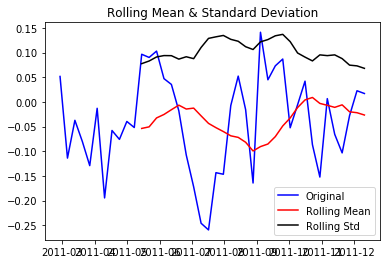

ADF Statistic: -3.7957887753220763
p-value: 0.002950696403371003
Critical Values:
	1%: -3.60098336718852
	5%: -2.9351348158036012
	10%: -2.6059629803688282


In [167]:
rolling_mean = pur_price.rolling(window=12).mean()
pur_price_minus_mean = pur_price - rolling_mean
pur_price_minus_mean.dropna(inplace=True)
get_stationarity(pur_price_minus_mean)

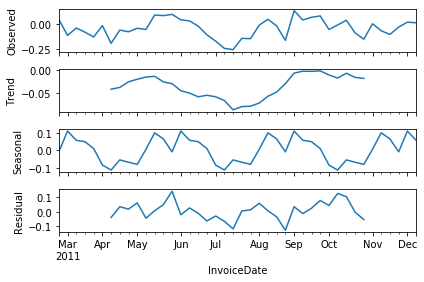

In [168]:
#decomposing times series into trend, seasonality, and noise
#freq of 13 due to peaks every ~3 months
decomp = seasonal_decompose(pur_price_minus_mean, model='additive', freq=13)
fig = decomp.plot()
plt.show()

In [169]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(pur_price_minus_mean.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.008
ARIMA(0, 0, 1) MSE=0.008
ARIMA(0, 0, 2) MSE=0.012
ARIMA(0, 1, 0) MSE=0.013
ARIMA(0, 1, 1) MSE=0.010
ARIMA(0, 1, 2) MSE=0.013
ARIMA(0, 2, 0) MSE=0.041
ARIMA(0, 2, 1) MSE=0.014
ARIMA(1, 0, 0) MSE=0.009
ARIMA(1, 0, 1) MSE=0.009
ARIMA(1, 0, 2) MSE=0.013
ARIMA(1, 1, 0) MSE=0.011
ARIMA(1, 2, 0) MSE=0.028
ARIMA(1, 2, 1) MSE=0.015
ARIMA(1, 2, 2) MSE=0.020
ARIMA(2, 0, 0) MSE=0.009
ARIMA(2, 1, 0) MSE=0.011
ARIMA(2, 1, 1) MSE=0.011
ARIMA(2, 1, 2) MSE=0.013
ARIMA(2, 2, 0) MSE=0.017
ARIMA(4, 0, 0) MSE=0.011
ARIMA(4, 1, 0) MSE=0.015
ARIMA(4, 1, 1) MSE=0.014
ARIMA(4, 2, 0) MSE=0.018
ARIMA(4, 2, 1) MSE=0.017
ARIMA(6, 0, 0) MSE=0.011
ARIMA(6, 0, 1) MSE=0.016
ARIMA(6, 1, 0) MSE=0.017
ARIMA(6, 2, 0) MSE=0.020
ARIMA(8, 0, 0) MSE=0.016
ARIMA(8, 1, 0) MSE=0.016
Best ARIMA(0, 0, 0) MSE=0.008


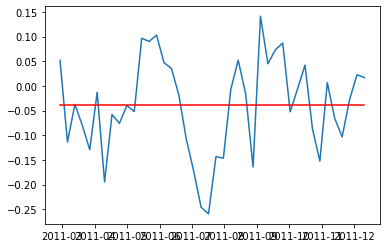

In [170]:
#using best ARIMA parameters from grid search to create model.
model = ARIMA(pur_price_minus_mean, order=(0,0,0))
results = model.fit()
plt.plot(pur_price_minus_mean)
plt.plot(results.fittedvalues, color='red')

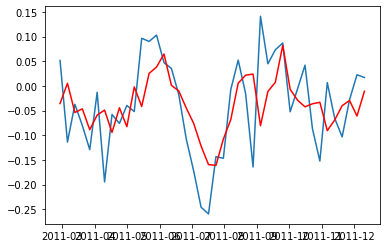

In [171]:
#using ARIMA parameters (4,0,0) with MSE=0.011.
model = ARIMA(pur_price_minus_mean, order=(4,0,0))
results = model.fit()
plt.plot(pur_price_minus_mean)
plt.plot(results.fittedvalues, color='red')

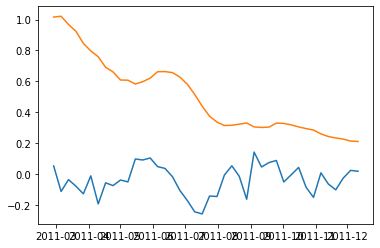

In [172]:
model_original(pur_price_minus_mean)

Text(0.5, 1.0, 'Price predictions for purchased products for 2012, based on 2011')

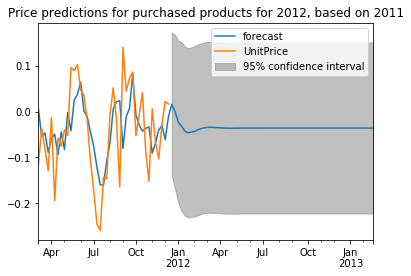

In [173]:
#using 104 as we have 12 months of data  (52 weeks), and I would like to predict the next year (52+52=104 total weeks)
results.plot_predict(1,104)
plt.title("Price predictions for purchased products for 2012, based on 2011")

Yet another model that has a wide range of 95% confidence intervals

#### <span style='color:Blue'> Conclusion: purchased products price and quantity, while slightly easier to fit a model to, don't offer much in predictive value due to their highly variable nature  </span>

For an informative look, I also looked at the top 20 purchased products and plotted those

In [174]:
top_20_bought = get_top_nums(normal, 'Description', 20)
top_20_bought

,Description,ValueCount
0,WHITE HANGING HEART T-LIGHT HOLDER,1929
1,JUMBO BAG RED RETROSPOT,1632
2,LUNCH BAG RED RETROSPOT,1340
3,PARTY BUNTING,1312
4,NATURAL SLATE HEART CHALKBOARD,1208
5,LUNCH BAG BLACK SKULL.,1184
6,SET OF 3 CAKE TINS PANTRY DESIGN,1125
7,ASSORTED COLOUR BIRD ORNAMENT,1089
8,JAM MAKING SET WITH JARS,1076
9,LUNCH BAG SPACEBOY DESIGN,1073


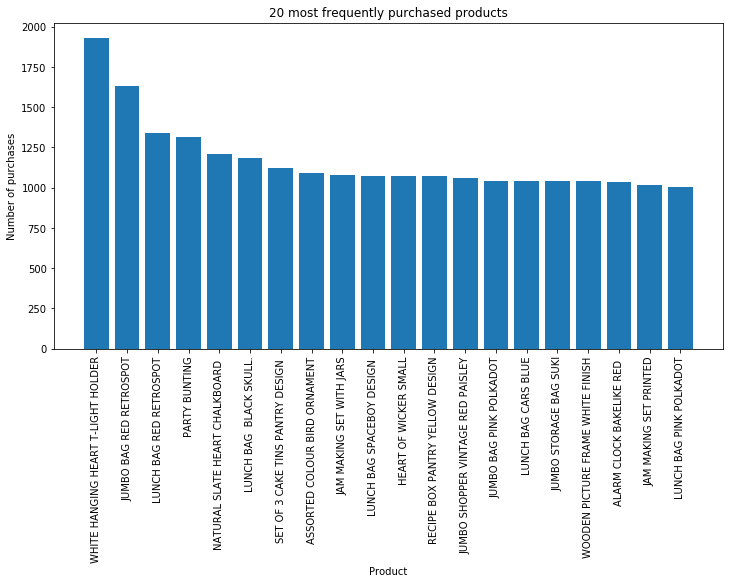

In [175]:
_ = plt.figure(figsize=[12,6])
_ = plt.bar(top_20_bought['Description'], height=top_20_bought['ValueCount'])
_ = plt.xlabel('Product')
_ = plt.xticks(rotation=90)
_ = plt.ylabel('Number of purchases')
_ = plt.title('20 most frequently purchased products')
plt.show()

I checked to see if any of the top purchased products were also in the top cancelled products by using an inner join. There were 6 that made the top 20 of boths lists.

In [176]:
common = can_top20.merge(top_20_bought, how='inner', on='Description')
common

,Description,ValueCount_x,ValueCount_y
0,JAM MAKING SET WITH JARS,87,1076
1,SET OF 3 CAKE TINS PANTRY DESIGN,74,1125
2,RECIPE BOX PANTRY YELLOW DESIGN,47,1070
3,JUMBO BAG RED RETROSPOT,44,1632
4,LUNCH BAG RED RETROSPOT,44,1340
5,WHITE HANGING HEART T-LIGHT HOLDER,42,1929
